In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
pd.set_option('display.max_columns', None)

### Andmete laadimine

In [248]:
with open("../config/marc_columns_to_keep.json", "r", encoding="utf8") as f:
    columns = json.load(f)["columns"]

with open("../config/marc_columns_dict.json", "r", encoding="utf8") as f:
    column_names = json.load(f)
    column_names_reverse = {val: key for key, val in column_names.items()}
    column_names_verbose = {key: f"{key}: {val}" for key, val in column_names.items()}

In [251]:
erb_est = pd.read_parquet("../data/converted/erb_books.parquet")
erb_non = pd.read_parquet("../data/converted/erb_non_estonian.parquet")

In [252]:
df_main = pd.concat([erb_est, erb_non])
df_main = df_main[columns]
del(erb_est, erb_non)
df_main

,001,003,006,008,020$a,041$a,041$h,080$a,100,130$a,...,648$a,650,651,655,700,710,740$a,752$c,752$d,856$u
0,b46991414,ErRR,<NA>,170928s2017 er ||||| |||||||| 0|est,9789949996414,<NA>,<NA>,638.132; 638.19; 581.162.3,"Riis, Marje (1955-) [autor]",<NA>,...,<NA>,mesilane [EMS012786]; tolmeldajad [EMS164127];...,Eesti (riik) [EMS131705],käsiraamatud (vormimärksõna) [EMS004071],"Karise, Reet (1977-) [autor]; Linask, Katrin (...",<NA>,<NA>,Harjumaa,<NA>,https://www.digar.ee/arhiiv/nlib-digar:328186
1,b1336974x,ErRR,m | d |,000118s1968 er a | |||||||| 0|est,9789916297667,<NA>,<NA>,37.032; 374.3,<NA>,<NA>,...,<NA>,isiksuse areng [EMS023604]; ideaalid [EMS02150...,<NA>,artiklikogumikud (vormimärksõna) [EMS026849],"Spriit, Edgar (1922-1993) [koostaja]; Kallas, ...",<NA>,<NA>,<NA>,<NA>,https://www.digar.ee/id/nlib-digar:967793
2,b23730717,ErRR,<NA>,080124s1931 er | |||||||| 0|est,<NA>,<NA>,<NA>,784.087.683,<NA>,<NA>,...,<NA>,eesti [EMS174969]; meeskoorid [EMS026211]; sel...,<NA>,kontserdikavad [EMS026200],<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,b20311771,ErRR,<NA>,050421s2004 er a | |||||||| 0|est,<NA>,est,ger,681.523.5,"Hesse, Stefan [autor]",<NA>,...,<NA>,pneumoautomaatika [EMS018199]; pneumaatika [EM...,<NA>,<NA>,"Soots, Rein [tõlkija]",<NA>,<NA>,Harjumaa,<NA>,<NA>
4,b14147348,ErRR,<NA>,000821s1960 er b | |||||||| 0|est,<NA>,est,<NA>,94; 63; 332.2,"Konks, Jaan (1902-1988) [autor]",<NA>,...,18. sajandi lõpp; 19. sajandi algus,feodalism [EMS010705]; pärisorjus [EMS010959];...,Eesti (riik) [EMS131705],<NA>,<NA>,Tartu Riiklik Ülikool,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88735,b14154390,ErRR,<NA>,001020s1889 er ||||| |||||||| 0|ger,<NA>,<NA>,<NA>,<NA>,"Lichinger, Friedrich (1864-1931) [autor]",<NA>,...,<NA>,krooton [EMS030578]; koor (botaanika) [EMS1541...,<NA>,magistritööd [EMS022163],<NA>,<NA>,<NA>,<NA>,"Tartu; Tartu, trükkimiskoht",<NA>
88736,b14067924,ErRR,<NA>,000626s1963 er | |||||||| 0|rus,<NA>,<NA>,<NA>,328.1; 342.538,<NA>,<NA>,...,<NA>,parlamendid [EMS005022]; istungjärgud [EMS015697],Eesti (riik) [EMS131705],stenogrammid [],<NA>,Eesti NSV Ülemnõukogu,<NA>,<NA>,<NA>,<NA>
88737,b24547335,ErRR,<NA>,090127s1913 ru ad | |||||||| 0|rus,<NA>,rus,<NA>,<NA>,"Фляксбергер, Константин Андреевич (1880-1942) ...",<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,"Tartu, trükkimiskoht",<NA>
88738,b14087741,ErRR,<NA>,000706s1962 er | |||||||| 0|rus,<NA>,<NA>,<NA>,625.7/.8 :658.5,<NA>,<NA>,...,<NA>,teedeehitus [EMS006055]; töökorraldus [EMS0212...,<NA>,õppematerjalid [EMS007196],<NA>,Tallinna Polütehniline Instituut [Tööstusökono...,<NA>,<NA>,<NA>,<NA>


### Abifunktsioonid

In [7]:
def roman_to_arabic(roman):
    # Mapping of Roman numerals to Arabic numerals
    roman_numerals = {
        'I': 1,
        'V': 5,
        'X': 10,
        'L': 50,
        'C': 100,
        'D': 500,
        'M': 1000
    }
    
    # Initialize the previous value and total
    prev_value = 0
    total = 0
    
    # Reverse the Roman numeral string for left-to-right calculation
    for char in reversed(roman):
        value = roman_numerals[char]
        
        # If the current value is less than the previous one, subtract it from the total; else add it
        if value < prev_value:
            total -= value
        else:
            total += value
        
        # Update the previous value
        prev_value = value
    
    return total

In [8]:
def missing_values_heatmap(df, verbose=True):
    plt.figure(figsize=(6,4))
    df_hm = df.copy()
    if verbose:
        df_hm = df_hm.rename(columns=column_names_verbose)

    print("Täidetus:")
    for col in df_hm.columns:
        print(f"{col}: {round((df_hm[col].notna().sum()/len(df_hm))*100)} %")
    sns.heatmap(df_hm.isna(), cbar=False, yticklabels=False, cmap='viridis')
    plt.title("Puuduvad väärtused")
    plt.show()

In [9]:
def regex_coverage(df, col, pattern):
    total_entries = len(df.loc[df[col].notna()])
    covered_values = 0
    for entry in df.loc[df[col].notna(), col].values:
        if re.search(pattern, entry):
            covered_values += 1

    print(f"Regex katab {covered_values} kirjet {total_entries} kirjest")
    print("Kaetus: ", round(covered_values/total_entries*100, 2), "%")

## Tulpade analüüs ja puhastamine

### Kontrollväljad (008)

In [357]:
df = df_main["008"].to_frame()

In [360]:
def clean_008(entry):
    if type(entry) == str:
        if len(entry) in range(38, 41):
            date_entered = entry[0:6]
            publication_date = entry[7:11]
            publication_place = entry[15:18]
            publication_language = entry[35:38]
            literary_form = entry[33]

            # check if fiction
            is_fiction = None
            if literary_form in [0, "0", "e", "i", "s"]:
                is_fiction = False
            elif literary_form in [1, "1", "d", "f", "h", "j", "p"]:
                is_fiction = True

            return date_entered, publication_date, publication_place, publication_language, is_fiction
    return None, None, None, None, None

In [361]:
df[["date_entered", "008_date", "008_place", "008_language", "is_fiction"]] = df["008"].apply(clean_008).to_list()
df["length"] = df["008"].apply(len)

In [447]:
def clean_entry_dates(dates):

    def parse_entry_dates(date):
        """Convert a date in the format YYMMDD to YYYY-MM-DD"""
        if isinstance(date, str):
            if re.match("\d{6}", date):
                year = int(date[:2])
                if year >= 70:  # Assuming no overlap and 1970 is the threshold
                    return '19' + date[:2] + "-" + date[2:4] + "-" + date[4:6]
                else:
                    return '20' + date[:2] + "-" + date[2:4] + "-" + date[4:6]
        return None

    dates = dates.apply(parse_entry_dates)
    dates = pd.to_datetime(dates, errors='coerce')

    # anything greater than the current date must be an insertion error
    today = pd.Timestamp.today().normalize()
    dates.loc[dates > today] = pd.NaT

    return dates

In [454]:
df["date_entered"] = clean_entry_dates(df["date_entered"])

In [455]:
df["date_entered"]

0       2017-09-28
1       2000-01-18
2       2008-01-24
3       2005-04-21
4       2000-08-21
           ...    
88735   2000-10-20
88736   2000-06-26
88737   2009-01-27
88738   2000-07-06
88739   2024-02-01
Name: date_entered, Length: 310281, dtype: datetime64[ns]

In [440]:
today = pd.Timestamp.today().normalize()

In [450]:
len(dates.loc[dates <= today])

309747

In [295]:
# not captured - maybe separator error?
df.loc[~df["length"].isin(range(38, 41))]

,008,008_date,008_place,008_language,length,genre
6691,230616t20232023er |||||s|||||||| 0|,None,None,None,35,None
127467,030130s191u er | |||||||| 0|est; 020523...,None,None,None,78,None
175133,,None,None,None,0,None
76932,190826s1623 gw ||||| |||||||| 0|lat; cr |n|...,None,None,None,54,None


In [12]:
df["008_language"].value_counts()[:20]

est    221539
rus     40255
eng     19201
ger     18478
lat      3353
fin      1969
swe      1701
fre       774
lav       616
lit       242
hun       226
pol       190
spa       178
ita       168
cze       128
ukr       126
dan       115
dut        96
bul        82
epo        77
Name: 008_language, dtype: int64

### ISBN (020a)

In [402]:
df = df_main["020$a"].to_frame()

In [27]:
df.sample(10)

,020$a
25977,9789916056257
154940,9789916088500
59156,9985535871
30778,<NA>
78114,<NA>
212159,<NA>
32697,9789287253309; 9789287253446
192890,<NA>
113075,9985570138
17657,9949404258


Täidetus:
020$a: isbn: 56 %


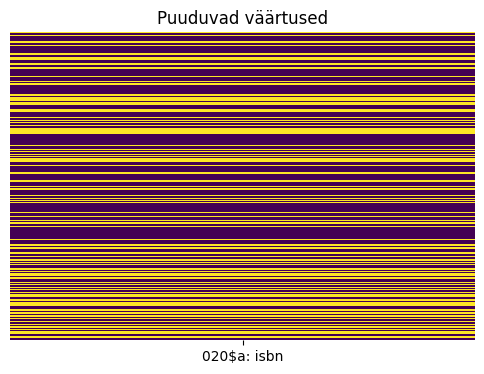

In [30]:
missing_values_heatmap(df)

In [31]:
import isbnlib

In [32]:
### testime ISBN-ide valideerimist
def validate_020(entry):
    try:
        if type(entry) == str:
            entry_split = np.array(entry.split("; "))
            valid_isbns = []
            for code in entry_split:
                code = isbnlib.clean(code)
                if isbnlib.is_isbn10(code):
                    valid_isbns.append(code)
                elif isbnlib.is_isbn13(code):
                    valid_isbns.append(code)
            return "; ".join(valid_isbns)#.replace("  ", " ")
        else:
            #print(entry, "not string")
            return None
    except:
        print(f"Could not process", entry)

In [33]:
#df = df.to_frame()
df["020$a_cleaned"] = df["020$a"].apply(validate_020)
df = df.convert_dtypes()
df.sample(10)

,020$a,020$a_cleaned
111146,<NA>,<NA>
47985,5867930866,5867930866
86980,<NA>,<NA>
63596,<NA>,<NA>
161586,<NA>,<NA>
23763,9789949819096,9789949819096
208859,9789949583478,9789949583478
98822,<NA>,<NA>
3248,<NA>,<NA>
35386,9789985214855,9789985214855


In [34]:
print('Kokku ISBN-iga kirjeid: ', len(df.loc[df["020$a"].notna()]))
print('Kirjeid, kus ISBN pole (tervenisti) valiidne: ', len(df.loc[df["020$a"] != df["020$a_cleaned"]]))
print('Valiidsete ISBN kirjete osakaal: ', round(len(df.loc[df["020$a"] == df["020$a_cleaned"]]) / len(df.loc[df["020$a"].notna()]), 3)*100, "%")

Kokku ISBN-iga kirjeid:  174558
Kirjeid, kus ISBN pole (tervenisti) valiidne:  497
Valiidsete ISBN kirjete osakaal:  99.7 %


### Keel, originaalkeel ja keelemärkus (041 a, h; 546a)

In [35]:
df = df_main[["041$a", "041$h", "546$a"]].copy()

Täidetus:
041$a: language: 35 %
041$h: language_original: 24 %
546$a: language_note: 11 %


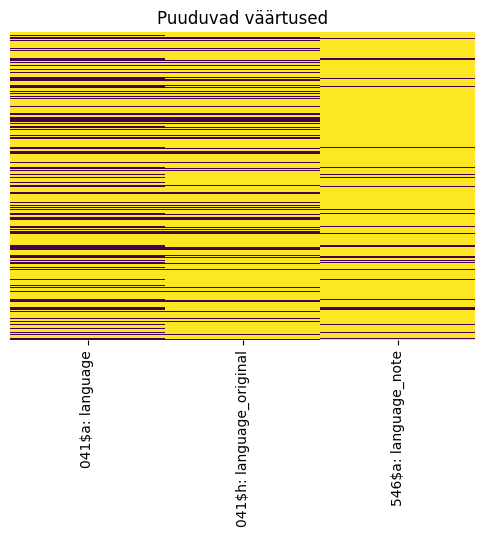

In [36]:
missing_values_heatmap(df)

In [37]:
### tundub, et tõlketeostel on alati kirjas mõlemad keeled, st koos originaalkeelega täidetakse keel
print(f'Kirjeid, kus pole originaalkeelt, aga on keel: {len(df.loc[(df["041$a"].notna()) & (df["041$h"].isna())])}')
print(f'Kirjeid, kus pole keelt, aga on originaalkeel: {len(df.loc[(df["041$a"].isna()) & (df["041$h"].notna())])}')

Kirjeid, kus pole originaalkeelt, aga on keel: 34339
Kirjeid, kus pole keelt, aga on originaalkeel: 0


In [38]:
### võrdleme kontrollvälja keelt (008) andmevälja keelega (041)
df[["008_place", "008_language"]] = df_main["008"].apply(clean_008).to_list()
df = df[["041$a", "041$h", "008_language"]]

In [39]:
df.sample(20)

,041$a,041$h,008_language
7250,est,eng,est
1144,eng,<NA>,eng
44001,<NA>,<NA>,est
23504,eng,<NA>,eng
108030,<NA>,<NA>,est
157992,rus,<NA>,est
179140,<NA>,<NA>,est
216999,<NA>,<NA>,est
35611,<NA>,<NA>,est
95799,est,eng,est


### Isikunimi (100) - ainult persons dataset jaoks

In [58]:
df = df_persons["100"].copy().to_frame()

In [59]:
df

,100
0,"Große, Rolf (1958-)"
1,"Vivolin, Malla (1982-)"
2,"Wernher, Johann Balthasar von (1675-1742)"
3,"Bulatov, Aleksandr (1945-)"
4,"Thiele, Bob (1955-)"
...,...
106235,"Iseli, Regula (1962-)"
106236,"Kull, Aare (1916-2004)"
106237,"McCabe, Vinton (1954-)"
106238,Aðalsteinn Ásberg Sigurðsson (1955-)


In [88]:
def extract_person_info(person_str):
    # Remove any titles enclosed in quotes
    person_str = re.sub(r': ".*?"', '', person_str)

    # Regular expression patterns
    pattern_with_date = r'^(.+?) \(([\d?]+)?-([\d?]+)?\)$'
    pattern_name_only = r'^(.+?)$'

    # Extract name and birth/death dates
    match = re.match(pattern_with_date, person_str)
    if match:
        name, birth_date, death_date = match.groups()
        birth_date = birth_date.strip() if birth_date else None
        death_date = death_date.strip() if death_date else None
        return name.strip(), birth_date, death_date
    
    # Handle the case where only the name exists
    match = re.match(pattern_name_only, person_str)
    if match:
        name = match.group(1)
        return name.strip(), None, None

    # Return an error if no pattern matched
    print(f"Error: '{person_str}' doesn't match expected patterns.")
    return None

In [89]:
df[["name", "birth_year", "death_year"]] = df["100"].apply(extract_person_info).to_list()

In [90]:
df["born_int"] = df["born"].astype("Int64", errors="ignore")
df["died_int"] = df["died"].astype("Int64", errors="ignore")

In [92]:
df.loc[df["100"].str.contains("u Jon, François")]

,100,name,born,died,born_int,died_int
556,"Du Jon, François (1591?-1677)","Du Jon, François",1591?,1677,1591?,1677
66850,"Du Jon, François (1545-1602)","Du Jon, François",1545,1602,1545,1602


#### Keelemärkus (546a)

In [70]:
### kas on mõtet neid kuidagi ühtlustada? nt:
### rööptekst inglise ja vene keeles -> eng, rus [rööptekst]
### Osa teksti prantsuse keeles -> fre [osa teksti]
df_main["546$a"].value_counts()[:30]

Kokkuvõte eesti keeles                           5827
Rööptekst vene keeles                            3057
Kokkuvõte inglise keeles                         2698
Rööptekst inglise keeles                         2325
Osa teksti vene keeles                           1295
Kokkuvõte saksa keeles                            863
Osa teksti inglise keeles                         721
Artiklite kokkuvõtted inglise keeles              657
Osa teksti eesti keeles                           549
Rööptekst saksa keeles                            521
Tekst eesti ja vene keeles                        480
Kokkuvõte vene keeles                             444
Tõlgitud vene keelest                             407
Rööptekst vene ja eesti keeles                    345
Rööptekst eesti keeles                            322
Osa teksti saksa keeles                           299
Sisukord ka vene keeles                           294
Tekst eesti ja inglise keeles                     246
Rööptekst inglise ja vene ke

### Pealkiri ja alapealkiri (245 a, b, n)

In [71]:
### vaatame üle nende tulpade kaetuse

df = df_main[["245$a", "245$b", "245$n"]].copy()

Täidetus:
245$a: title: 100 %
245$b: title_remainder: 54 %
245$n: title_part_nr: 8 %


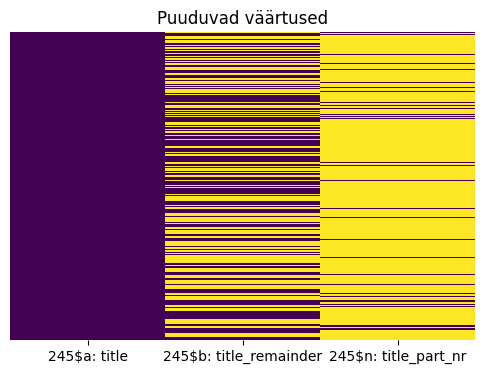

In [72]:
missing_values_heatmap(df)

In [73]:
### OTSUS: ühtlustada 245$n regexi abil

In [83]:
# võtame 2000 sagedasemat väärtust
sample_values = df["245$n"].value_counts()[:5000].index

In [77]:
with open("regex_tests/245n_samples.txt", "a", encoding="utf8") as f:
    for line in sample_values:
        f.write(line)
        f.write("\n")

In [112]:
# regex pattern
# old
# pattern_245n = r"(?:([Nn]r\.?\s)|Album\s|Triloogia\s)?(?P<n>(?P<araabia>\d{1,2})|(?P<rooma>\b(?=[MDCLXVI]+\b)(M{0,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3}))\b)|(?P<arvsna>(?P<a1>[Ee]{1,2}[sd]{1,2}i?m[eaä]n{1,2}e)|(?P<a2>[Tt][eõö]ine)|(?P<a3>[Kk]olmas)|(?P<a4>[Nn]eljas)|(?P<a5>[VWvw]i{1,2}es)|(?P<a6>[Kk]u{1,2}es)|(?P<a7>[Ss]eitsmes)|(?P<a8>[Kk]ah{1,2}eksas)|(?P<a9>[Üü]h{1,2}eksas)|(?P<a11>([Üü](ks|he)teist)|(?P<a12>[Kk]a(ks|he)teist))?(?P<a10>[Kk]ümnes))|(?P<AB>A|B))(\.)?\s?(?P<p>(?:\[?)([A-zöõäü]+)(?:\.?\]?))?"

pattern_245n = r"(?:([Nn]r\.?\s)|Album\s|Triloogia\s|Part\s|Heft\s|Том\s|[Tt]h?eil\s|[Кк]нига\s|[Чч]асть\s)?(?P<n>(?P<araabia>\d{1,2})|(?P<rooma>\b(?=[MDCLXVI]+\b)(M{0,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3}))\b)|(?P<arvsna>(?P<a1>([Ee]{1,2}[sd]{1,2}i?m[eaä]n{1,2}e)|([Ee]rst[ers]?)|([Ff]irst|[Oo]ne)|([Pp]remi[èe]re?)|([Пп]ерв(ый|ая|ое)))|(?P<a2>([Tt][eõö]ine)|([Zz]we[iy]t[ers]?)|([Ss]econd|[Tt]wo)|([Dd]euxi[èe]me)|([Вв]тор(ой|ая|ое)))|(?P<a3>([Kk]olmas)|([Dd]ritt[ers]?)|([Tt]hird|[Tt]hree)|([Tt]roi[sx]i[èe]me)|([Тт]рет(ий|ья|ье)))|(?P<a4>([Nn]eljas)|([Vv]iert[ers]?)|([Ff]our(th)?|[Ff]our)|([Cc]inqui[eè]me)|([Чч]етв[её]рт(ый|ая|ое)))|(?P<a5>([VWvw]i{1,2}es)|([Ff]ünft[ers]?)|([Ff]ifth|[Ff]ive)|([Cc]inqui[eè]me)|([Пп]ят(ый|ая|ое)))|(?P<a6>([Kk]u{1,2}es)|([Ss]echst[ers]?)|([Ss]ix(th)?|[Ss]ix)|([Ss]ixi[èe]me)|([Шш]ест(ой|ая|ое)))|(?P<a7>([Ss]eitsmes)|([Ss]iebt[ers]?)|([Ss]even(th)?|[Ss]even)|([Ss]epti[èe]me)|([Сс]едьм(ой|ая|ое)))|(?P<a8>([Kk]ah{1,2}eksas)|([Aa]cht[ers]?)|([Ee]ight(th)?|[Ee]ight)|([Hh]uiti[èe]me)|([Вв]осьм(ой|ая|ое)))|(?P<a9>([Üü]h{1,2}eksas)|([Nn]eunt[ers]?)|([Nn]ine(th)?|[Nn]ine)|([Nn]euvi[èe]me)|([Дд]евят(ый|ая|ое)))|(?P<a11>([Üü](ks|he)teist)|(?P<a12>[Kk]a(ks|he)teist))?(?P<a10>([Kk]ümnes)|([Zz]ehnt[ers]?)|([Tt]en(th)?|[Tt]en)|([Dd]ixi[èe]me)|([Дд]есят(ый|ая|ое))))|(?P<AB>A|B))(\.)?\s?(?P<p>(?:\[?)([A-Za-zА-Яа-яöõäüéè]+)(?:\.?\]?))?"

In [113]:
# katsetame kaetuse protsenti
print(f"Regex katab {df['245$n'].value_counts()[:2000].sum()} kirjet {len(df.loc[df['245$n'].notna()])} kirjest")
print("Kaetus: ", round((df["245$n"].value_counts()[:2000].sum()/len(df.loc[df["245$n"].notna()]))*100, 2), "%")

Regex katab 23102 kirjet 24463 kirjest
Kaetus:  94.44 %


In [114]:
# millised jäävad katmata?

for entry in sample_values:
    match = re.search(pattern=pattern_245n, string=entry)
    if match:
        # print("\n")
        # print(entry)
        # print(match.groupdict())
        pass
    else:
        print(entry)

Lisaköide
Täiendusköide
Lisa
Lõpuosa
Книга друга
Zweeter Theil
Lõbusad loomad
Lisad
Рабочая тетрадь А
Värvid
Üldosa
Vahvad värvid
Рабочая тетрадь "Б"
Loomad
Lisavihik
Eriväljaanne
Valdkond H
Nelli ramatut
Toinen kirja
А
Capita duo
Pirma dalla
Particula posterior
В
Секция биохимии и физиологии
Pars prior
Partea a treia şi a patra
Particula prima
Első rész
Otrā un trešā grāmata
Fjärde sägnen
Секция  химии
Pars altera
Специальный выпуск
Ensimmäinen kirja
IIIt[es] Heft Mit fünf Tafeln
автореферат ... кандидата педагогических наук
Section S
Б
Ezimene köide
Valdkond F
Valdkond G
E
Liber quartus
Supplementsband
Tomus primus
Inaugural-Dissertation
Дополнительный выпуск
Premiére série, premiére livraison
Секция
IIt[es] Heft Mit fünf Tafeln
Рассказы о мученниках
Inaugural-Dissertation zur Erlangung des Grades eines Doctors der Medicin


In [115]:
def clean_245n(entry: str, pattern=pattern_245n):
    
    if type(entry) == str:
        match = re.search(pattern, entry)
        if match:
            groups = match.groupdict()
            n = None
            p = None

            if groups["n"]:
                if groups["araabia"]:
                    n = groups["araabia"]
                elif groups["rooma"]:
                    n = str(roman_to_arabic(groups["rooma"]))
                elif groups["arvsna"]:
                    for key, val in groups.items():
                        if re.search("a\d{1,2}", key):
                            if val is not None:
                                n = key.lstrip("a")
                                break
                elif groups["AB"]:
                    if groups["AB"] == "A":
                        n = "1"
                    elif groups["AB"] == "B":
                        n = "2"
                    
            if groups["p"]:
                p = f" [{groups['p'].lstrip('[').strip(']')}]"
            else:
                p = ''

            #print(groups)
            return n+p

In [146]:
clean_245n("Osa 1")

'1'

In [145]:
# näited
sample = df["245$n"].loc[df["245$n"].notna()].sample().values[0]
print(sample, "\t-\t", clean_245n(sample, pattern_245n))

I osa 	-	 1 [osa]


**TODO**: 1-3, III-IV jne, I ja II, 3 ja 4

### Tõlkepealkiri (246g, 130a, 240a)

Täidetus:
246: title_varform: 32 %
130$a: uniform_title: 0 %
240$a: unifrom_title: 2 %


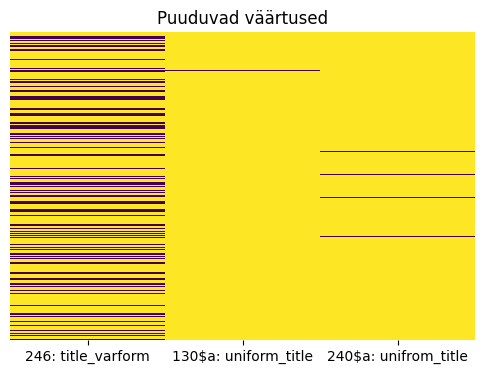

In [255]:
df = df_main[["246", "130$a", "240$a"]]
missing_values_heatmap(df)

In [257]:
df = df_main[["245$a", "100", "700", "041$a", "041$h", "246", "130$a", "240$a"]]

In [259]:
df.loc[(df["246"].notna())].sample(10)

,245$a,100,700,041$a,041$h,246,130$a,240$a
153660,Graafiline (re)presentatsioon & varjualune =,<NA>,"Kuldkepp, Helin [toimetaja]; Vilbiks, Laura Li...",eng,est,Graphic (re)presentation & shelter; Arhitektuu...,<NA>,<NA>
118070,Perekond Berg ja Sangaste,<NA>,"Ross, Heino (1929-2016) [koostaja]",<NA>,<NA>,Sangaste,<NA>,<NA>
134723,Rakwere Wastastikuse Kredit-Ühisuse põhjuskiri,<NA>,<NA>,<NA>,<NA>,Rakvere Vastastikkuse Krediidiühisuse põhjuskiri,<NA>,<NA>
23733,VIII kirikunoorte päevad,<NA>,<NA>,<NA>,<NA>,8. kirikunoorte päevad; Kaheksandad kirikunoor...,<NA>,<NA>
212285,Helesinine magamistuba ja teisi jutte,"Pilcher, Rosamunde (1924-2019) [autor]","Planhof, Maia (1941-) [tõlkija]; Teesalu, Milv...",est,eng,The blue bedroom and other stories [Eesti keeles],<NA>,<NA>
156257,Chuggington,<NA>,<NA>,est,eng,Chuggington. Bumper sticker book [Eesti keeles],<NA>,<NA>
202036,Kellassepa tütar,"Morton, Kate (1976-) [autor]","Tõnismann, Lii [tõlkija]; Nurmik, Kai (1969-) ...",est,eng,The clockmaker's daugter [Eesti keeles],<NA>,<NA>
48457,Itaalia,<NA>,"Belford, Ross [autor]; Jepson, Tim [autor]; Te...",ita,eng,Eyewitness travel guide. Italy [Eesti keeles],<NA>,<NA>
200900,Arwuwalla ülesanded algkoolidele,"Jurevitš, Grigori (1866-1910) [autor]",<NA>,est,rus,Arvuvalla ülesanded algkoolidele; Arwuwalla ül...,<NA>,<NA>
71232,Kadrina Põllumeeste Seltsi poolt korraldatud p...,<NA>,<NA>,<NA>,<NA>,II Kadrina Põllumeeste Seltsi poolt korraldatu...,<NA>,<NA>


In [356]:
def extract_original_titles(df):
    """Extracts the original title from the fields 246 (combined from 260$a and 260$g during conversion), 240$a and 130$a"""
    def handle_246(x):
        """Extracts the original title from the 246 field (always followed by the language in square brackets)"""
        if isinstance(x, str):
            processed_values = [val.rsplit(" [", maxsplit=1)[0] for val in x.split("; ") if re.search(r"\[.+\]$", val)]
            result = "; ".join(processed_values)
            return result if result else pd.NA
        else:
            return pd.NA

    # Add values from 246 to a new column
    df["title_original"] = pd.NA
    df["title_original"] = df["246"].apply(handle_246)

    # Where 246 did not provide an original title, use 240 and then 130
    df["title_original"] = df["title_original"].fillna(df["240$a"]).fillna(df["130$a"])

    return df["title_original"]


def clean_246(x):
    """Removes original titles from the 246 field and keeps other varform titles. Use after extract_original_titles()"""
    if isinstance(x, str):
        return "; ".join([val for val in x.split("; ") if not re.search(r"\[.+\]$", val)])
    else:
        return pd.NA
    
df["title_varform"] = df["246"].apply(cleanup_246)

return df

In [338]:
sample = df.sample(50000).copy()
test = extract_original_title(sample)

In [355]:
test.loc[test["130$a"].notna()].sample(10)

,245$a,100,700,041$a,041$h,246,130$a,240$a,title_original,title_varform
85383,Säravad jõulud,<NA>,"Lane, Lily [illustreerija]; Meredith, Samantha...",est,eng,<NA>,Santa & Friends,<NA>,Santa & Friends,<NA>
18185,Õpi kujundeid ja vastandeid koos krokodill Kar...,<NA>,"Arak, Evelin (1989-) [tõlkija]; Biene, Liina (...",est,eng,<NA>,Learn the shapes and opposites with Jeff the c...,<NA>,Learn the shapes and opposites with Jeff the c...,<NA>
133687,"Looduse nõud ja jõud, ehk, Ühe puu jutuajamine...",<NA>,"Mäe, Rene (1987-) [koostaja]; Mäe, Rene (1987-...",<NA>,<NA>,Ühe puu jutuajamine raamatukogu külastajaga,Looduse nõud ja jõud,<NA>,Looduse nõud ja jõud,Ühe puu jutuajamine raamatukogu külastajaga
122851,Rahahullus,<NA>,"Arak, Evelin (1989-) [tõlkija]; Kinkar, Eva (1...",est,eng,<NA>,Money madness,<NA>,Money madness,<NA>
108553,Arva ära! Loodus,<NA>,"Zolotareva, Lena [illustreerija]; Shendrik, Sv...",est,eng,<NA>,Guess what's in nature,<NA>,Guess what's in nature,<NA>
21903,Minu armsaim loomaraamat,<NA>,"Sooneste, Eve (1975-) [tõlkija]; Tomingas, Tii...",est,ger,<NA>,Meine liebsten Tiere,<NA>,Meine liebsten Tiere,<NA>
9176,Värvin ja mängin,<NA>,"Volmer, Kirke [tõlkija]",est,fre,<NA>,Je colorie et je joue,<NA>,Je colorie et je joue,<NA>
10994,Loomade kuningriik,<NA>,"Edwards, Mat (1966-) [illustreerija]; Harkness...",est,eng,<NA>,The animal kingdom,<NA>,The animal kingdom,<NA>
60281,Kirjuta. [Kass],<NA>,"Laumets, Jane [tõlkija]; Biene, Liina (1987-) ...",est,eng,<NA>,Wipe clean: first writing skills,<NA>,Wipe clean: first writing skills,<NA>
134093,Loomade maailm,<NA>,<NA>,est,eng,<NA>,Animal world,<NA>,Animal world,<NA>


In [342]:
test.loc[178650, "246"]

'Critical historiography of modern architecture : narrating modernity in the architectural histories of Leo Gens and Leonhard Lapin in the 1960s-1980s'

In [177]:
def extract_original_title(row):
    # Check if any of the specified columns are populated
    if row[['246$a', '246$g', '130$a', '240$a']].notna().any():
        # pre 2022: 246$a (title varform) may be the original title
        if pd.notna(row['246$a']):
            # 246$g is used if 246$a contains the original title
            if pd.notna(row['246$g']):
                # if both 246$g and 240$a are present, use 240$a
                if pd.notna(row['240$a']):
                    return row['240$a']
                else:
                    # 240$a can sometimes be marked in 130$a
                    if pd.notna(row['130$a']):
                        return row['130$a']
                    # if not, return 246$g
                    return row['246$a']
            # post 2022: original title marked in 130$a or 240$a
            else:
                if pd.notna(row['130$a']) and pd.isna(row['240$a']):
                    return row['130$a']
                elif pd.notna(row['240$a']) and pd.isna(row['130$a']):
                    return row['240$a']
        else:
            if pd.notna(row['130$a']):
                return row['130$a']
            elif pd.notna(row['240$a']):
                return row['240$a']
    else:
        return None

In [207]:
def extract_original_titles(df):
    # Mask for rows where any of the specified columns are populated
    mask_any_populated = df[['246$a', '246$g', '130$a', '240$a']].notna().any(axis=1)
    
    # Pre 2022: 246$a may be the original title
    condition_1 = pd.notna(df['246$a'])
    
    # 246$g is used if 246$a contains the original title
    condition_2 = pd.notna(df['246$g'])
    
    # Both 246$g and 240$a are present, use 240$a
    condition_3 = pd.notna(df['240$a'])
    
    # Original title marked in 130$a
    condition_4 = pd.notna(df['130$a'])
    
    # Conditions to determine the original title
    result = np.select(
        [
            condition_1 & condition_2 & condition_3,
            condition_1 & condition_2 & ~condition_3 & condition_4,
            condition_1 & condition_2 & ~condition_3 & ~condition_4,
            condition_1 & ~condition_2 & condition_4 & ~condition_3,
            condition_1 & ~condition_2 & condition_3 & ~condition_4,
            ~condition_1 & condition_4,
            ~condition_1 & condition_3
        ],
        [
            df['240$a'],
            df['130$a'],
            df['246$a'],
            df['130$a'],
            df['240$a'],
            df['130$a'],
            df['240$a']
        ],
        default=None
    )
    
    return pd.Series(result, index=df.index)

In [227]:
sample = df.sample(10000).reset_index()

In [228]:
sample["title_original"] = extract_original_titles(sample)

In [231]:
sample.loc[sample["title_original"].notna() & sample["246$g"].str.contains(";")].sample(10)

,index,245$a,100,700,041$a,041$h,246$a,246$g,130$a,240$a,title_original
6726,180648,Tiziani poeg,"Musset, Alfred de (1810-1857) [autor]","Keevallik, Sirje (1943-) [tõlkija]; Keevallik,...",est,fre,Iludusmärk; Le fils du Titien; La Mouche,Eesti keeles; Eesti keeles,<NA>,<NA>,Iludusmärk; Le fils du Titien; La Mouche
2650,4782,Sonette,"Shakespeare, William (1564-1616) [autor]","Oras, Ants (1900-1982) [tõlkija]",est,eng,Suveöö unenägu; Othello; The sonnets; A midsum...,Eesti keeles; Eesti keeles; Eesti keeles,<NA>,<NA>,Suveöö unenägu; Othello; The sonnets; A midsum...
7196,196911,Hermeneutika universaalsus,"Gadamer, Hans-Georg (1900-2002) [autor]","Tool, Andrus (1960-) [tõlkija]; Tool, Andrus (...",est,ger,Hermeneutik - Ästhetik - praktische Philosophi...,Eesti keeles; Eesti keeles,<NA>,<NA>,Hermeneutik - Ästhetik - praktische Philosophi...
7114,109568,Enigma variatsioonid,"Schmitt, Éric-Emmanuel (1960-) [autor]","Schmitt, Éric-Emmanuel (1960-): ""Vabamõtleja"";...",est,fre,Variations énigmatiques; Le Libertin,Eesti keeles; Eesti keeles,<NA>,<NA>,Variations énigmatiques; Le Libertin
7354,156989,Kus sa oled?,"Levy, Marc (1961-) [autor]","Kanarbik, Tiina [tõlkija]; Variksaar, Viivi (1...",est,fre,Où es-tu?; Finding you,Eesti keeles; Eesti keeles,<NA>,<NA>,Où es-tu?; Finding you
2349,36930,В суровый край,"Vilde, Eduard (1865-1933) [autor]","Андрезен, Ниголь (1899-1985) [järelsõna autor]",rus,est,Külmale maale; Mäeküla piimamees; Молочник из ...,Vene keeles; Vene keeles,<NA>,<NA>,Külmale maale; Mäeküla piimamees; Молочник из ...
3252,40854,Kiirjooksjad,"Andersen, Hans Christian (1805-1875) [autor]","Antik, Agnes (1903-1995) [tõlkija]; Luts, Kari...",est,dan,Hurtigløberne; Springfyrene; Kærestefolkene,Eesti keeles; Eesti keeles; Eesti keeles,<NA>,<NA>,Hurtigløberne; Springfyrene; Kærestefolkene
5696,101571,Täht,"Kazakevitš, Emmanuil (1913-1962) [autor]","Palmiste, Endel (1930-2014) [kujundaja]; Väli,...",est,rus,Зося; Иван; Звезда,Eesti keeles; Eesti keeles; Eesti keeles,<NA>,<NA>,Зося; Иван; Звезда
4950,192121,Rasmuste raamat,"Lindgren, Astrid (1907-2002) [autor]","Beekman, Vladimir (1929-2009) [tõlkija]; Rea-S...",est,swe,"Rasmus pa luffen; Rasmus, Pontus och Toker; Ka...",Eesti keeles; Eesti keeles; Eesti keeles,<NA>,<NA>,"Rasmus pa luffen; Rasmus, Pontus och Toker; Ka..."
8139,84020,Punapea,"Renard, Jules (1864-1910) [autor]","Niinepuu-Kiik, Piret (1958-) [illustreerija]; ...",est,fre,Looduslood; Histoires naturelles; Poil de carotte,Eesti keeles; Eesti keeles,<NA>,<NA>,Looduslood; Histoires naturelles; Poil de carotte


In [206]:
test2.loc[test2["original_title"].notna()]

,index,245$a,100,700,041$a,041$h,246$a,246$g,130$a,240$a,original_title
6,207193,Mööda kiusatustest,"Alpi, Eero (1885-1933) [autor]","Elango, Julius (1895-1976) [tõlkija]",est,fin,Ohi kiusauksen,Eesti keeles,<NA>,<NA>,Eesti keeles
7,51828,Ohtlik armas,"Marr, Melissa (1972-) [autor]","Raid, Bibi (1980-) [tõlkija]; Soomets, Triin (...",est,eng,Wicked lovely,Eesti keeles,<NA>,<NA>,Eesti keeles
10,141041,Särisev side,"Wild, Meredith (1982-) [autor]","Haugasmägi, Lii [tõlkija]; Kuremägi, Jana [toi...",est,eng,Hardwired,Eesti keeles,<NA>,<NA>,Eesti keeles
13,56333,Sammhaaval edasi,"Simsion, Graeme C (1956-) [autor]","Buist, Anne [autor]; Suits, Leena [tõlkija]; R...",est,eng,<NA>,<NA>,<NA>,Two steps forward,Two steps forward
17,148212,Tenerife pihtimused,"Cawley, Joe [autor]","Veske, Tanel [tõlkija]; Pirso, Urve (1971-) [t...",est,eng,More ketchup than salsa. Confessions of a Tene...,Eesti keeles,<NA>,<NA>,Eesti keeles
...,...,...,...,...,...,...,...,...,...,...,...
9970,115082,Agendi mäng,"Le Carré, John (1931-2020) [autor]","Eichenbaum, Allan [tõlkija]; Kaer, Krista (195...",est,eng,Agent running in the field,Eesti keeles,<NA>,<NA>,Eesti keeles
9971,161142,Salamõrtsuka teekond,"Hobb, Robin (1952-) [autor]","Habicht, Juhan (1954-) [tõlkija]; Kaer, Kaaren...",est,eng,Assassin's quest,Eesti keeles,<NA>,<NA>,Eesti keeles
9972,23038,The Estonian State Open-Air Museum,<NA>,"Vunder, Elle (1939-) [koostaja]; Kersna, Heino...",eng,est,Eesti Riiklik Vabaõhumuuseum,Inglise keeles,<NA>,<NA>,Inglise keeles
9979,55778,Kõige sobimatum peigmees,"Michaels, Kasey [autor]","Planhof, Maia (1941-) [tõlkija]; Saar, Krista ...",est,eng,A most unsuitable groom,Eesti keeles,<NA>,<NA>,Eesti keeles


In [205]:
test2["original_title"]

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
9995    NaN
9996    NaN
9997    NaN
9998    NaN
9999    NaN
Name: original_title, Length: 10000, dtype: object

### Editsiooniandmed (250a)

In [40]:
df = df_main["250$a"].copy()

Täidetus:
250$a: edition_statement: 7 %


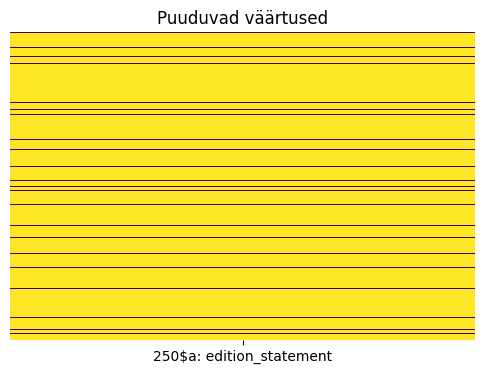

In [41]:
missing_values_heatmap(df.to_frame())

In [244]:
pattern_250a = r"(?P<n>(?P<araabia>\[?\d{1,2}\]?(\.|-о?[еe]|nd|rd|th|),?)|(?P<arvsna>(?P<a1>([Ee]simene)|[Ff]irst|[Ee]rste[rs]?)|(?P<a2>[Tt]eine|[Zz]weite[rs]?|[Ss]econd)|(?P<a3>[Kk]olma[ts]|[Tt]hird|[Dd]ritte[rs]?)|(?P<a4>[Nn]elja[st]|[Ff]ourth|[Vv]ierte[rs]?)|(?P<a5>[Vv]iies|[Ff]ifth|[Ff]üfte[rs]?)|(?P<a6>[Kk]uues|[Ss]ixth|[Ss]echste[rs]?)|(?P<a7>[Ss]eitsme[st]|[Ss]eventh|[Ss]iebte[rs]?)|(?P<a8>[Kk]ahh?eksa(s|mat)|[Ee]ighth?|[Aa]chte[rs]?)|(?P<a9>[Üü]hh?eksa(s|mat)|[Nn]inth|[Nn]eunte[rs]?)|(?P<a10>[Kk]ümne(s|mat)|[Tt]enth|[Zz]enthe[rs]?)))?,?\s?(?:(([Tt]äiend|[Pp]arand|[Uu]uend|[Aa]jakohast)(atud)?|[Üü]mbert(ööt(atud)?)?|[Mm]uutm(ata)?|[Mm]uud(et(ud)?)?|[Vv]erb|Повтор(ное|\.)|доп\.|[Rr]ev|[Vv]erm|[Vv]erbesserte)\.?(\sja\s(täiend|parand))?\.?\s)?(?P<tr>([Ee]sma|[Ee]ri|[Ää]ra|[Uu]us|[Kk]ordus|[Üü]mber|[Ff]aksiimile|[Pp]re|[Rr]e|[Ss]onder)?(tr(ükk|yck)?|vä?lj(aanne)?|([Aa]b)?dr(uck)?|Aufl(age)?|ed(ition)?|print|vers(i?ion)?|uppl|pain(os)?|изд))?"

In [213]:
def clean_250a(entry: str, pattern=pattern_250a):
    if type(entry) == str:
        match = re.search(pattern, entry)
        if match:
            groups = match.groupdict()
            n = None
            tr = None

            if groups["n"]:
                if groups["araabia"]:
                    n = groups["araabia"]
                    n = "".join([char for char in n if char.isnumeric()])
                elif groups["arvsna"]:
                    for key, val in groups.items():
                        if re.search("a\d{1,2}", key):
                            if val is not None:
                                n = key.lstrip("a")
                                break
            if groups["tr"]:
                tr = groups["tr"]
                if n is None:
                    n = "+"

            if n or tr:
                return f"{n or ''} [{tr or ''}]"
            
            return "+"
            
        return None

In [165]:
#df = df.to_frame()

In [240]:
# näited
sample = df["250$a"].loc[df["250$a"].notna()].sample().values[0]
print(sample, "\t-\t", clean_250a(sample, pattern_250a))

2-е изд 	-	 2 [изд]


In [245]:
df["250$a"].apply(clean_250a, pattern=pattern_250a)

0          None
1          None
2          None
3        2 [tr]
4          None
          ...  
88735      None
88736      None
88737      None
88738      None
88739      None
Name: 250$a, Length: 310281, dtype: object

### Koht, aeg, kirjastus dubleerimise kaotamine (260 a, b, c vs 264 a, b c)

**Probleem**: mingil hetkel 2022. aasta jooksul hakati 260 asemel kasutama 264.

In [411]:
df = df_main[["260$a", "260$b", "260$c", "264$a", "264$b", "264$c"]].copy()

Täidetus:
260$a: publication_place: 95 %
260$b: publisher: 92 %
260$c: publication_date: 95 %
264$a: production_publication_distribution_place: 5 %
264$b: producer_publisher_distributer_name: 5 %
264$c: production_publication_distribution_date: 5 %


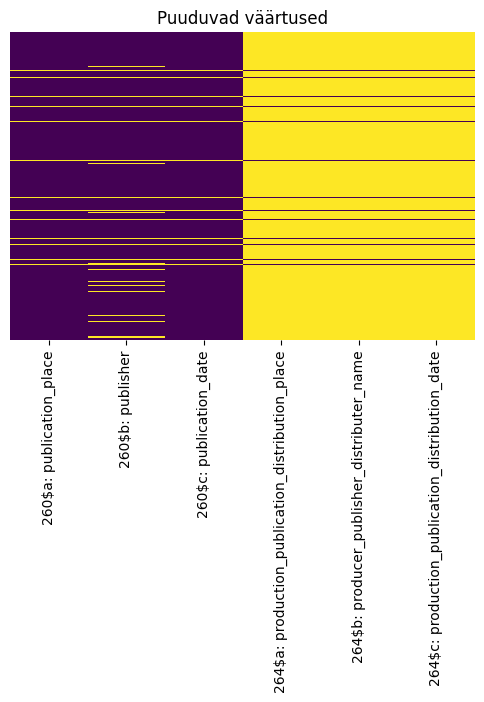

In [412]:
missing_values_heatmap(df)

In [413]:
### igaks juhuks topelkontroll, ega pole kirjeid, kus on täidetud nii 260 kui 264

for sub in ["a", "b", "c"]:
    rows_with_values_in_both_columns = df[df[f'260${sub}'].notna() & df[f'264${sub}'].notna()]
    print("260", sub, "topeltkirjete arv:", len(rows_with_values_in_both_columns))

260 a topeltkirjete arv: 0
260 b topeltkirjete arv: 0
260 c topeltkirjete arv: 0


In [414]:
### kuna väärtus on alati kas ainult 260 või 264 peal, siis jääb üle need lihtsalt kokku tõsta. Jätame alles väljad 260 ja täiendame neid väljadega 264
def add_260abc_264abc(df):
    for sub in ["a", "b", "c"]:
        df[f"260${sub}"] = df[f"260${sub}"].fillna(df[f"264${sub}"])

add_260abc_264abc(df)

### Aastaarvude puhastamine (260c)

In [415]:
# peab tegelema sellist sorti eranditega
yr = df["260$c"].copy()
yr = yr[yr.notna()]
for i in yr[~yr.str.contains(r"^\d{4}$", na=False)].sample(10):
    print(i)

c2007
c2006
c2019
2023; ©2023
c2011
c2008
c2019
c2003
c2008
c2018


In [416]:
pattern_260c = re.compile(r"(?:c|(?P<copyright>©)|tsens(eeritud|\.)\s*)?((?P<year>\d{4})(?:\.0)?(?:\?)?|(?P<decade>\d{3}-\?)|(?P<century>\d{2}--\?))")

In [417]:
def clean_260c(entry, pattern=pattern_260c, min_year=1500, max_year=2024):
    """Funktsioon võtab sisse välja 260$c ehk ilmumisaasta kirje ning tagastab aasta ning kümnendi arvulisel kujul."""
    output_year = None
    output_decade = None
    # output_century = None

    if type(entry) != str:
        if isinstance(entry, list):
            entry = "; ".join(entry)
        else:
            try:
                entry = str(entry)
            except:
                return None, None

    # 2022; 2022    
    if ";" in entry:
        entry_split = entry.split("; ")
        years = []
        for part in entry_split:
            match = re.search(pattern, part)
            if match:
                part_year = match.groupdict()["year"]
                if part_year is not None:
                    if part_year not in years:
                        if match.groupdict()["copyright"] is None:
                            years.append(part_year)
                        else:
                            if len(years) == 0:
                                years.append(part_year)

        if len(years) == 1:
            output_year = int(years[0])
        else:
            try:
                output_year = min([int(y) for y in years])
            except ValueError:
                return None, None

    else:
        match = re.search(pattern, entry)
        if match:
            groups = match.groupdict()
            # 2022
            if groups["year"] is not None:
                output_year = int(groups["year"])
            # 196-?
            elif groups["decade"] is not None:
                output_decade = int(groups["decade"].strip("?").replace("-", "0"))
            # 18--?
            # elif groups["century"] is not None:
            #     output_century = int(groups["century"].strip("?").replace("-", "0"))

    if output_year:
        if output_year in range(min_year, max_year+1):
            output_decade = output_year // 10 * 10
            # output_century = output_year // 100 * 100
        else:
            output_year = None

    # elif output_decade:
    #     output_century = output_decade // 10 * 10

    return (output_year, output_decade)

In [418]:
df[["260$c_cleaned", "decade"]] = df["260$c"].apply(clean_260c).to_list()
df = df.convert_dtypes()

In [419]:
df[["260$c", "260$c_cleaned", "decade"]].sample(10)

,260$c,260$c_cleaned,decade
98156,2014,2014,2010
79161,2020,2020,2020
1456,2014,2014,2010
86033,c2009,2009,2000
140679,1935,1935,1930
206834,1929,1929,1920
135205,2011,2011,2010
48691,1814 (,1814,1810
35474,2014,2014,2010
73869,2002,2002,2000


In [872]:
# ebastandardsemaid näiteid
sample = yr[~yr.str.contains(r"^\d{4}$", na=False)].sample(10)
cleaned_sample = sample.apply(clean_260c)

for s, c in zip(sample, cleaned_sample):
    print(s, "\t\t", c)

c2018 		 (2018, 2010)
c2007 		 (2007, 2000)
c2003 		 (2003, 2000)
c2005 		 (2005, 2000)
c2002 		 (2002, 2000)
c2017 		 (2017, 2010)
c2017 		 (2017, 2010)
c2011 		 (2011, 2010)
c2020 		 (2020, 2020)
c2013 		 (2013, 2010)


In [871]:
# millised jäävad katmata?
for val in df["260$c"].values:
    val_cleaned = clean_260c(val)
    if val_cleaned == (None, None):
        if val is not None:
            print(val, "\t\t", val_cleaned)
# nagu näha, siis need, mis on vaid sajandi täpsusega (19--?), ja vigased kanded

19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
18--? 		 (None, None)
19--? 		 (None, None)
J. Felsberg ja A. Tetermann 		 (None, None)
J. F. Steffenhagen und Sohn 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
18--? 		 (None, None)
19--? 		 (None, None)
18--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
1291 [p.o. 1921] 		 (None, None)
1291 [p.o. 1921] 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
Tallinn 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
19--? 		 (None, None)
[19--?] ( 		 (None, None)
19--? 		 (None, None)
19--

### 3. Füüsilised omadused (300 a, b, c)

In [146]:
df = df_main[["300$a", "300$b", "300$c"]].copy()

Täidetus:
300$a: physical_extent: 99 %
300$b: physical_details: 53 %
300$c: physical_dimensions: 90 %


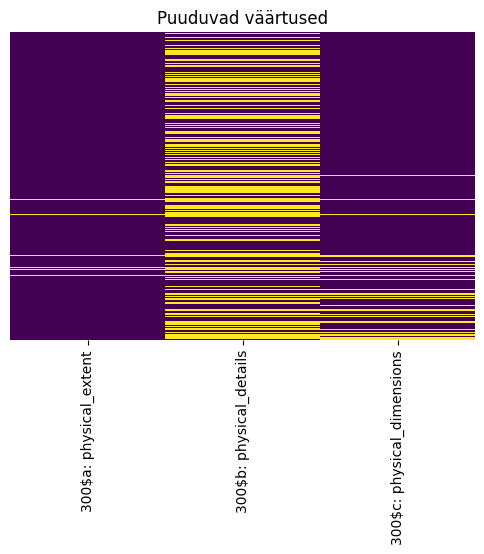

In [147]:
missing_values_heatmap(df)

In [148]:
### kuna tegu on väga hästi täidetud tulpadega, võiks need regexiga ära puhastada ja vajadusel eraldi tulpadeks lahku lüüa

#### 300$a

In [168]:
### teeme sellest tulbast konkreetselt lehekülgede arvu tulba, st võtame välja lk arvu seal, kus võimalik. e-raamatud ja võrguväljaanded jätame hetkel kõrvale.
for i in df["300$a"].value_counts().index[:200]:
    print(i)

1 võrguväljaanne (epub)
16 lk
32 lk
1 võrguressurss (epub)
1 e-raamat
64 lk
24 lk
48 lk
8 lk
96 lk
20 lk
40 lk
80 lk
15 lk
56 lk
12 lk
1 võrguväljaanne (pdf)
15, [1] lk
72 lk
36 lk
128 lk
31 lk
7, [1] lk
28 lk
31, [1] lk
112 lk
47, [1] lk
160 lk
63, [1] lk
144 lk
52 lk
44 lk
23 lk
88 lk
63 lk
47 lk
[16] lk
[4] lk
14 lk
192 lk
104 lk
60 lk
[8] lk
68 lk
[10] lk. koos kaanega
23, [1] lk
19 lk
39 lk
30 lk
95, [1] lk
95 lk
120 lk
11 lk
79 lk
176 lk
55 lk
79, [1] lk
27 lk
76 lk
22 lk
208 lk
256 lk
35 lk
136 lk
224 lk
39, [1] lk
84 lk
[32] lk
71 lk
[8] lk. koos kaanega
7 lk
127, [1] lk
[24] lk
18 lk
43 lk
100 lk
111 lk
152 lk
46 lk
127 lk
11, [1] lk
55, [1] lk
168 lk
240 lk
143 lk
92 lk
71, [1] lk
19, [1] lk
26 lk
10 lk
87 lk
62 lk
59 lk
159 lk
184 lk
15, [1] lk. koos kaanega
51 lk
38 lk
108 lk
200 lk
159, [1] lk
4 lk
1 võrguressurss (pdf)
111, [1] lk
103 lk
34 lk
143, [1] lk
42 lk
191, [1] lk
216 lk
94 lk
29 lk
67 lk
[2] lk
54 lk
116 lk
288 lk
87, [1] lk
191 lk
78 lk
175 lk
207, [1] lk
[12] 

In [150]:
pattern_300a = re.compile(r"(?P<arv>\[?\d{1,4}\]?),?(\s*)?(?P<sulud>\[\d+\])?\s+(?P<uhik>lk|l\b|(nummerdamata\s)?lehekülge|voldik|CD-ROM|(võrgu(väljaanne|ressurss)|e-raamat))")

In [439]:
pattern_300a = re.compile(r"(([IVXL]+,?\s)|(1\s(voldik|võrgu(väljaanne|ressurss))\s\())?(?P<vahemik>(?:[Ll]k\.?\s)?\d{1,4}\-\d{1,4})?(?P<arv>\b\d{1,4})?,?(\s*)?(?P<sulud>\[\d+\])?\s*(?P<uhik>lk|l\b|(nummerdamata\s)?lehte|lehekülge?|voldik|CD-ROM|(võrgu(väljaanne|ressurss)|e-raamat))?")

In [440]:
# testime kaetust
regex_coverage(df, "300$a", pattern_300a)

Regex katab 216836 kirjet 216836 kirjest
Kaetus:  100.0 %


In [441]:
# millised jäävad katmata?
sample_values = df["300$a"].value_counts()[:200].index
for entry in sample_values:
    match = re.search(pattern=pattern_300a, string=entry)
    if match:
        # print("\n")
        # print(entry)
        # print(match.groupdict())
        pass
    else:
        print(entry)

In [442]:
def clean_300a(entry: str, pattern=pattern_300a):
    
    if type(entry) == str:
        match = re.search(pattern, entry)
        if match:
            lk = None
            groups = match.groupdict()
            if groups["uhik"]:
                if groups["uhik"] in ["l", "lk", "lehte", "lehekülg", "lehekülge", "nummerdamata lehekülge"]:
                    if groups["vahemik"]:
                        start, end = groups["vahemik"].split("-")
                        start = "".join([char for char in start if char.isnumeric()])
                        lk = int(end) - int(start)
                    elif groups["arv"]:
                        lk = int(groups["arv"])
                    elif groups["sulud"]:
                        lk = int(groups["sulud"].lstrip("[").strip("]"))
            elif groups["vahemik"]:
                start, end = groups["vahemik"].split("-")
                start = "".join([char for char in start if char.isnumeric()])
                lk = int(end) - int(start)

            # print(groups)
            return lk

In [443]:
re.search(pattern_300a, "Lk. 56-72").groupdict()

{'vahemik': 'Lk. 56-72', 'arv': None, 'sulud': None, 'uhik': None}

In [445]:
clean_300a("Lk. 56-72")

16

In [446]:
# näited
sample = df["300$a"].loc[df["300$a"].notna()].sample().values[0]
print(sample, "\t-\t", clean_300a(sample, pattern_300a))

48 lk 	-	 48


In [447]:
df["300$a_cleaned"] = df["300$a"].apply(clean_300a)
df = df.convert_dtypes()

In [451]:
df.loc[df["300$a"].str.contains("-")].sample(10)

,300$a,300$b,300$c,300$a_cleaned
169666,1 e-raamat,<NA>,<NA>,<NA>
184842,1 e-raamat (epub),<NA>,<NA>,<NA>
169412,1 e-raamat,<NA>,<NA>,<NA>
99192,"95, [1], 30 lk. [anne 1-4]",ill. kaas,16 cm,<NA>
125493,"[141]-309, XIV lk",<NA>,19 cm,<NA>
167521,1 e-raamat,<NA>,<NA>,<NA>
110810,"Lk. 794-801, [1]",<NA>,23 cm,7
172814,1 e-raamat,<NA>,<NA>,<NA>
171960,1 e-raamat,<NA>,<NA>,<NA>
101818,Lk. 121-131,<NA>,22 cm,10


#### 300$b

In [118]:
### tundub, et selle tulba võib teha lihtsalt 1/0 tulbaks - kui midagi on märgitud, siis on raamat illustreeritud
df["300$b"].value_counts()[:10]

ill                 80868
ill., portr         10670
ill. kaas            4182
illustratsioonid     3940
portr                2664
ill., ill. kaas      2582
ill., kaart          2185
joon                  977
fot                   916
ill., noot            740
Name: 300$b, dtype: int64

In [119]:
def clean_300b(entry):
    if type(entry) == str:
        return True
    else:
        return False

In [120]:
df["300$b_cleaned"] = df["300$b"].apply(clean_300b)

In [121]:
df.sample(10)

,300$a,300$b,300$c,300$b_cleaned
131983,[93] lk,NaN,21 cm,False
41063,117 lk,NaN,20 cm,False
39485,175 lk,ill,24 cm,True
78335,128 lk,joon,21 cm,True
10619,"45 lk., 2 l. ill",ill,21 cm,True
78572,148 lk,ill,21 cm,True
8757,"18 lk., 7 l. ill",ill,21 cm,True
143412,16 lk,ill,21 cm,True
163943,[36] lk. koos kaanega,ill,21 cm,True
7185,47 lk,NaN,21 cm,False


#### 300$c

In [122]:
### proovime kätte saada sentimeetrid, mis juhendi järgi tähendavad raamatu kõrgust
df["300$c"].loc[df["300$c"].notna()].sample(10)

150204    20 cm
70360     20 cm
159931    30 cm
149457    15 cm
17772     21 cm
213692    23 cm
52875     19 cm
139659    25 cm
88300     20 cm
210298    22 cm
Name: 300$c, dtype: object

In [123]:
def clean_300c(entry):
    if type(entry) == str:
        entry = entry.strip().lstrip()
        # formaat NN cm
        if re.match("\d{1,3}\s?cm", entry):
            entry = entry.split("cm")[0].strip()
        # kataloogimisviga cm -> cn
        elif re.match("\d{1,3}\s?cn", entry):
            entry = entry.split("cn")[0].strip()
        # kahe mõõdu (NN x NN cm) puhul võtame esimese arvu, kuna teine arv märgitakse vaid siis, kui laius on kõrgusest suurem
        elif re.match("\d{1,3}\s?[x]\s?\d{1,3}\s?cm", entry):
            entry = entry.split("x")[0].split(" cm")[0].strip()
        
        if re.match("\d{1,3}$", entry):
            return int(entry)
        else:
            return None

In [147]:
# näited
sample = df["300$c"].loc[df["300$c"].notna()].sample().values[0]
print(sample, "\t-\t", clean_300c(sample))

20x27 cm 	-	 20


In [389]:
df["300$c_cleaned"] = df["300$c"].apply(clean_300c).convert_dtypes()

In [406]:
df[["300$c", "300$c_cleaned"]].sample(10)

,300$c,300$c_cleaned
208675,30 cm,30
137291,30 cm,30
152713,22 cm,22
192194,<NA>,<NA>
10780,26 cm,26
102116,25 cm,25
73561,20 cm,20
28586,21 cm,21
183783,21 cm,21
119025,18 cm,18


### Amet (374a)

In [4]:
df_persons = pd.read_parquet("../data/converted/nle_persons.parquet")

In [16]:
df = df_persons["374$a"].copy()
df.value_counts()
### inglise ja eestikeelsed segamini, aga ilmselt ei ole mõtet siin hakata harmoniseerima

kirjanik                              2294
ajaloolane                            1040
Authors                               1015
College teachers                       994
Composers                              939
                                      ... 
kutsekoolitaja                           1
Design writer; Journalists               1
Jazz musicians; Flügelhorn player       1
College teachers, Part-time              1
Reggae musicians                         1
Name: 374$a, Length: 4171, dtype: Int64

### Sugu (375a)

In [19]:
df_persons.loc[df_persons["375$a"] == "ajaloolane"]

,001,003,008,040$a,040$b,040$c,040$e,046$f,075$a,100,374$a,375$a,400$a,400$d,670$a,670$u,680$i,043$c,372$a,370$e,372$2,373$a,377$a,046$g,370$a,370$b,035$a,040$d,046$2,370$2,373$2,374$2,375$2,500$w,500$i,500$a,663$a,663$b,670$b,370$s,053$a,368$c,368$2,370$c,371$a,371$b,371$e,400$c,046$s,378$q,667$a,675$a,373$s,373$t,400$b,510$a,510$b,400$q,046$v,680$a,500$c,024$a,024$2,024$1,053$c,053$5,370$t,500$d,400$w,370$f,377$l,042$a,065$a,065$2,065$5,678$a,700,046$t,510$w,510$i,368$d,043$a,371$c,371$d,372$u,374$s,374$t,374$v,371$m,046$a,410$a,410$c,370$u,370$v,372$v,374$u,368$a,370$g,005,024$0,371$v,371$u,370$1,678$u,046$u,410$d,500$e,043$b,373$v,411$a,368$s,368$t,500$q,400$t,376$a,510$0,053$b,374$f,373$1,500$p,400$e,500$b,400$n,373$b,378$a,374$1,672$a,672$f,672$b,372$s,510$4,510$1,377$g,043$d,672$w,400$s,670$i,440$a,440$d,400$m,368$1,500$0,670$h,690$i,373$0,780$i,373$u,372$t,580$i,677$a,378$v,376$2,681$i,375$s,375$t,072$a,040$p,400$r,371$s,371$t,377$2,511$w,511$i,511$a,400$f,680$u,670$n,500$1,374$p,046$k,380$a,500$t,400$1,670$8,679$a,679$u,680$d,046$q,671$a,671$t,376$b,500$n,530$w,530$i,530$a,070$a,670$1,400$p,400$g,378$u,370$3
66558,a12556804,ErRR,231006|||aznnnaabn || ||| c,ErTUR,est,ErTUR,rda,19620102,persoon,"Kolpakidi, Aleksandr (1962-)",mees,ajaloolane,"Aleksandr Kolpakidi; Колпакиди, Александр Иван...",1962-; 1962-,VIAF; Vikipeedia,http://viaf.org/viaf/68837369; https://ru.wiki...,Vene ajaloolane ja kirjanik,<NA>,<NA>,<NA>,<NA>,<NA>,rus,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
71585,a12712097,ErRR,240925|||aznnnaabn || ||| c,ErTUR,est,ErTUR,rda,19380405,persoon,"Struve, Tilman (1938-2014)",<NA>,ajaloolane,Tilman Struve,1938-2014,VIAF; Vikipeedia,http://viaf.org/viaf/5054482; https://de.wikip...,Saksa ajaloolane,de,<NA>,<NA>,<NA>,<NA>,mees,20141218,"Dresden, Saksamaa","Düsseldorf, Saksamaa",<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [32]:
df = df_persons["375$a"].copy()
df.value_counts()[50:].index

Index(['persoon; mees', 'Tokyo, Jaapan; mees', 'õppejõud; mees', 'professor',
       'mwwa', 'male; Men', 'Law teachers', 'Femles', 'nane', 'lcdgt',
       'female; Women', 'persoon; Males',
       'Composition teachers (Music); Females', 'mees; mees', 'mes', 'mess',
       'aine'],
      dtype='string')

In [27]:
def clean_375a(entry: str) -> str: 
    
    mapping = {'mees': 'mees',
                'naine': 'naine',
                'male': 'mees',
                'Males': 'mees',
                'Females': 'naine',
                'female': 'naine',
                'Women': 'naine',
                'Men': 'mees',
                'males': 'mees',
                'Male': 'mees',
                'sugu': None,
                'Female': 'naine',
                'females': 'naine',
                'male; Males': 'mees',
                'men': 'mees',
                'eng': None,
                'ajaloolane': None,
                'Females; naine': 'naine',
                'Non-binary people': 'non-binary',
                'meed': 'mees',
                'kirjanik': None,
                'Males; Armenians': 'mees',
                'not known': None,
                ' mees': 'mees',
                'mee': 'mees',
                '2': None,
                'Authors; Males': 'mees',
                'women': 'naine',
                'saksa': None,
                'Transgender people; Males; Transgender men': 'non-binary',
                'mees; male': 'mees',
                'fre': None,
                'kunstnik': None,
                'Women; naine': 'naine',
                'põlisrahvaste uurija': None,
                'Males; Males': 'mees',
                'tõlkija': None,
                'male; Architects': 'mees',
                'vene': None,
                'Males; eng': 'mees',
                'Males $2 lcdgt; Females': None,
                'mees0': 'mees',
                'naine; female': 'naine',
                'majandusteadlane': None,
                'filosoofiadoktor': None,
                'rus': None,
                'Males; Fantasy fiction; Authors': 'mees',
                'lit': None,
                'transgender woman; male; female': 'non-binary',
                'Music teachers; Males': 'mees',
                'persoon; mees': 'male',
                'Tokyo, Jaapan; mees': 'mees',
                'õppejõud; mees': 'mees',
                'professor': None,
                'mwwa': 'mees',
                'male; Men': 'mees',
                'Law teachers': None,
                'Femles': 'naine',
                'nane': 'naine',
                'lcdgt': None,
                'female; Women': 'naine',
                'persoon; Males': 'mees',
                'Composition teachers (Music); Females': 'naine',
                'mees; mees': 'mees',
                'mes': 'mees',
                'mess': 'mees',
                'aine': 'naine'}
    
    return mapping.get(entry, None)

In [35]:
#df = df.to_frame()
df["cleaned"] = df["375$a"].apply(clean_375a)

In [36]:
df

,375$a,cleaned
0,mees,mees
1,naine,naine
2,<NA>,None
3,<NA>,None
4,<NA>,None
...,...,...
106235,<NA>,None
106236,<NA>,None
106237,<NA>,None
106238,<NA>,None


### Bibliograafia/register (504a)

In [441]:
df = df_main["504$a"].copy().to_frame()

In [442]:
### Tundub, et bibliograafia ja register on eraldiseisvalt märgitud, seega võiks nende olemasolu eraldi käsitleda.
df.value_counts()[:30]

504$a                                                             
Sisaldab bibliograafiat                                               17381
Sisaldab registrit                                                     6234
Bibliograafia joonealustes märkustes                                   2316
Sisaldab bibliograafiat ja registrit                                   2227
Bibliograafia artiklite lõpus                                          1559
Sisaldab registreid                                                     799
Bibliograafia raamatu lõpus                                             545
Bibliograafia peatükkide lõpus                                          375
Bibliograafia joonealustes märkustes. - Sisaldab registrit              313
Sisaldab bibliograafiat ja registreid                                   263
Bibliograafia märkustes                                                 229
Bibliograafia artiklite lõpus ja joonealustes märkustes                 166
Bibliograafia ettekan

In [447]:
def clean_504a(entry):
    if type(entry) == str:
        b = ''
        r = ''
        if re.search("[Bb]ibliograafia", entry):
            b = "b"
        if re.search("[Rr]egist(er|rit)", entry):
            r = "r"

        return b+r

In [448]:
df["504$a_cleaned"] = df["504$a"].apply(clean_504a)

In [453]:
df.loc[df["504$a"].notna()].sample(10)

,504$a,504$a_cleaned
186599,Bibliograafia lk. 111-[112],b
153063,Sisaldab bibliograafiat,b
174795,Sisaldab bibliograafiat,b
178090,Sisaldab bibliograafiat,b
114601,Sisaldab bibliograafiat,b
206021,Bibliograafia joonealustes märkustes,b
91516,Sisaldab bibliograafiat,b
154138,Sisaldab bibliograafiat ja registrit,br
199073,Sisaldab bibliograafiat ja registrit,br
154730,Sisaldab bibliograafiat,b


### Digiteerimine e. reproduktsioon (533 a, d)

In [10]:
df = df_main[["533$a", "533$d"]].copy()

Täidetus:
533$a: repro_type: 20 %
533$d: repro_date: 20 %


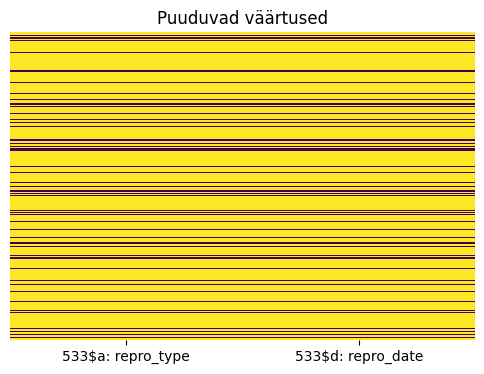

In [11]:
# nagu näha, siis kasutatakse neid kahte tulpa alati koos.
missing_values_heatmap(df)

In [12]:
### igaks juhuks topelkontroll, ega pole kirjeid, kus on täidetud nii 533$a kui 533$d
### nagu näha, siis 62 juhul on aasta puudu, aga see ei ole takistuseks
rows_with_only_533a = df[df['533$a'].notna() & df['533$d'].isna()]
rows_with_only_533d = df[df['533$a'].isna() & df['533$d'].notna()]
print("Kirjeid, kus ainult repro märge:", len(rows_with_only_533a))
print("Kirjeid, kus ainult repro aasta:", len(rows_with_only_533d))

Kirjeid, kus ainult repro märge: 62
Kirjeid, kus ainult repro aasta: 0


In [13]:
df["533$a"].value_counts()

Elektrooniline reproduktsioon                        61446
Elektrooniline reproduktsioon; Elektrooniline ...      442
aElektrooniline reproduktsioon                           7
Elektrooniline reproduktsioon; Elektrooniline ...        6
Elektrooniline reproduktsioon. Tartu : Tartu Ü...        4
 Elektrooniline reproduktsioon                           3
Elektrooniline reroduktsioon                             2
Elektrooniline reproduktsioon. Tartu : Eesti K...        1
9789916503232 (pdf)Elektrooniline reproduktsioon         1
Elektrooniline reproduktsioon; Elektrooniline ...        1
Eektrooniline reproduktsioon                             1
TÄISTEKST: http://hdl.handle.net/10062/39457             1
Elektrooniline reproduktsioon Rahvusarhiivi ek...        1
Kättesaadav ka digiteerituna                             1
lektrooniline reproduktsioon                             1
Name: 533$a, dtype: Int64

In [14]:
df["533$d"].value_counts()[:20]

2022          15337
2023          10904
2019           4547
2021           4533
2019-2021      4240
2018           3644
2020           3281
2017           2890
2024           2739
2016           2540
2012           1689
2015           1640
2014           1251
2013           1140
2011            888
2022; 2022       68
2009             55
2010             49
2012; 2015       35
2012; 2016       23
Name: 533$d, dtype: Int64

In [464]:
# 533$a saab muuta booleaniks (digiteeritud jah/ei)
# 533$d on seega sisuliselt digiteerimise aasta

#### 533$a

In [15]:
def clean_533a(entry):
    if type(entry) == str:
        return True
    else:
        return False

In [16]:
df["533$a_cleaned"] = df["533$a"].apply(clean_533a)

In [18]:
df.sample(10)

,533$a,533$d,533$a_cleaned
15668,Elektrooniline reproduktsioon,2019,True
38354,<NA>,<NA>,False
40961,<NA>,<NA>,False
72945,<NA>,<NA>,False
67459,<NA>,<NA>,False
8422,Elektrooniline reproduktsioon,2022,True
191359,Elektrooniline reproduktsioon,2015,True
12633,Elektrooniline reproduktsioon,2019-2021,True
214761,Elektrooniline reproduktsioon,2023,True
63584,<NA>,<NA>,False


#### 533$d

In [19]:
match = re.match(r"\d{4}(\.0|\w+)", "2022.0")
match.string
match.string[:4]

'2022'

In [20]:
pattern_533d = re.compile(r"^(\d{4}(-\d{4})?)(\;\s\d{4}(-\d{4})?)*")

In [21]:
re.findall("\d{4}", "2012; 2013")

['2012', '2013']

In [22]:
def clean_533d(entry, pattern=pattern_533d, min_year=2000, max_year=2024):
    if type(entry) != str:
        entry = str(entry)
    match = re.match(pattern, entry)
    if match:
        year = match.string
        if re.match(r"\d{4}(\.0|\w+)", year):
            year = year[:4]
        return year

In [42]:
# näited
sample = df["533$d"].loc[df["533$d"].notna()].sample().values[0]
print(sample, "\t-\t", clean_533d(sample))

2017 	-	 2017


In [43]:
df["533$d_cleaned"] = df["533$d"].apply(clean_533d)

In [79]:
df.sample(10)

,533$a,533$d,533$a_cleaned,533$d_cleaned
80175,<NA>,<NA>,False,None
195046,<NA>,<NA>,False,None
8405,<NA>,<NA>,False,None
179984,<NA>,<NA>,False,None
40327,<NA>,<NA>,False,None
196074,<NA>,<NA>,False,None
117634,<NA>,<NA>,False,None
123845,Elektrooniline reproduktsioon,2024,True,2024
8207,<NA>,<NA>,False,None
188698,<NA>,<NA>,False,None


### Sisu- ja žanrimärksõnad (650, 651, 655)

#### Sisumärksõnad (650 a, 0)

In [185]:
df = df_main[["650$a", "650$0"]]

Täidetus:
650$a: subject_topic: 96 %
650$0: subject_topic_thesaurus: 95 %


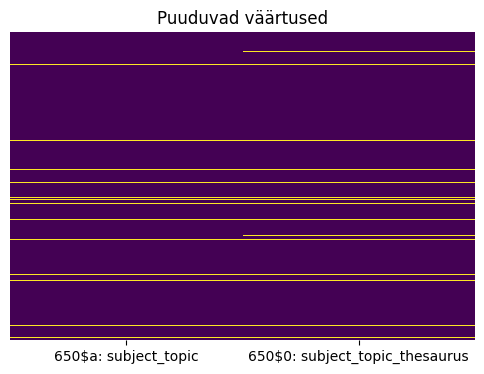

In [186]:
missing_values_heatmap(df)

In [203]:
# kui palju on kannete osakaal, kus märksõnale on EMS lisamata?
print(round(len(df.loc[(df["650$a"].notna()) & (df["650$0"].isna())]) / len(df), 2)*100, "%")
# väga vähe

1.0 %


In [204]:
# kontrollime igaks juhuks, kas on ridu, kus on EMS lingid, aga märksõna ennast mitte
print(len(df.loc[(df["650$a"].isna()) & (df["650$0"].notna())]))
# ei ole

0


In [206]:
### Märksõnade ja linkide dubleerimine tundub veidi mõttetu.
### Äkki hoopis tõstaks EMS IDd märksõnade järele nurksulgudesse (usuõpetus [022767]) ja lisaks seletuse dokumentatsiooni?

#### Žanrimärksõnad (655 a, 0)

In [208]:
df = df_main[["655$a", "655$0"]].copy()

Täidetus:
655$a: subject_genre: 85 %
655$0: subject_genre_thesaurus: 58 %


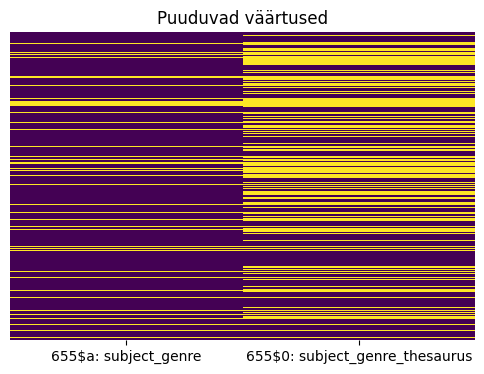

In [209]:
missing_values_heatmap(df)

In [210]:
# kontrollime igaks juhuks, kas on ridu, kus on EMS lingid, aga märksõna ennast mitte
df.loc[(df["655$a"].isna()) & (df["655$0"].notna())]

,655$a,655$0


In [216]:
# samas on väga palju kandeid, kus EMS lingid puuduvad
print(len(df.loc[(df["655$a"].notna()) & (df["655$0"].isna())]))

# näiteks
df.loc[(df["655$a"].notna()) & (df["655$0"].isna())].sample(10)

# nendel märksõnadel peaks kõigil EMS id olema - kas hakkame seda tööd ise tegema?

60411


,655$a,655$0
124826,nimestikud,NaN
78699,õppekavad,NaN
36890,statistilised andmed,NaN
192585,kokaraamatud,NaN
119950,stenogrammid,NaN
7278,töövihikud,NaN
107226,kokaraamatud,NaN
109320,palveraamatud,NaN
97370,õppekavad; kavandid (projektid),NaN
166758,infotrükised,NaN


#### Kohamärksõnad (651 a, 0)

In [217]:
df = df_main[["651$a", "651$0"]].copy()

Täidetus:
651$a: subject_geographic_name: 30 %
651$0: subject_geographic_thesaurus: 30 %


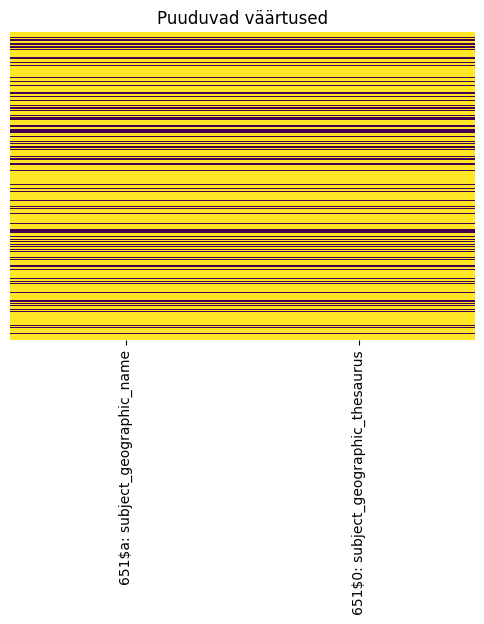

In [218]:
missing_values_heatmap(df)

In [219]:
# kontrollime igaks juhuks, kas on ridu, kus on EMS lingid, aga märksõna ennast mitte
df.loc[(df["651$a"].isna()) & (df["651$0"].notna())]
# ei ole

,651$a,651$0


In [ ]:
# tundub, et kõik on juba normkujul ja harmoniseerida pole vaja
df.loc[df["651$a"].notna()].sample(10)

,651$a,651$0
158832,NSV Liit,https://ems.elnet.ee/id/EMS131700
32556,Eesti (riik),https://ems.elnet.ee/id/EMS131705
35066,Eesti (riik),https://ems.elnet.ee/id/EMS131705
153274,Venemaa; Peterburi,https://ems.elnet.ee/id/EMS131683; https://ems...
41337,Ida-Virumaa,https://ems.elnet.ee/id/EMS131716
35728,NSV Liit,https://ems.elnet.ee/id/EMS131700
111992,Riia,https://ems.elnet.ee/id/EMS133101
138066,Järvamaa,https://ems.elnet.ee/id/EMS131723
186993,Heimtali,https://ems.elnet.ee/id/EMS135497
135714,Tartu,https://ems.elnet.ee/id/EMS131949


### Seeriaandmed (490a)

In [148]:
df = df_main["490$a"].copy()

Täidetus:
490$a: series_statement: 21 %


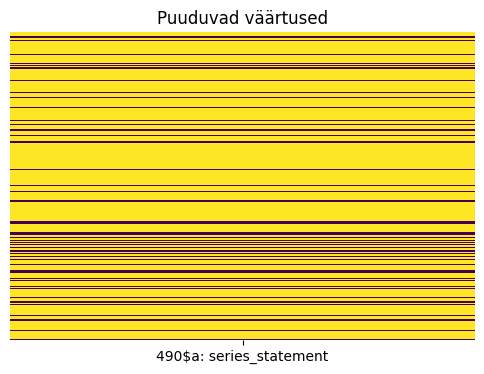

In [149]:
missing_values_heatmap(df.to_frame())

In [156]:
df.sample(10)

63046                                                   NaN
169629                                                  NaN
6342                                                    NaN
86663                                                   NaN
27240                             Eesti riikline statistika
108199                                                  NaN
199446                                  Harlequin romantika
186702                                                  NaN
40177     Teaduse saavutusi ja eesrindlikke kogemusi põl...
135641              Saaremaa Merekultuuri Seltsi toimetised
Name: 490$a, dtype: object

### Üldmärkused (500a)

In [246]:
df = df_main["500$a"].copy()

Täidetus:
500$a: general_note: 31 %


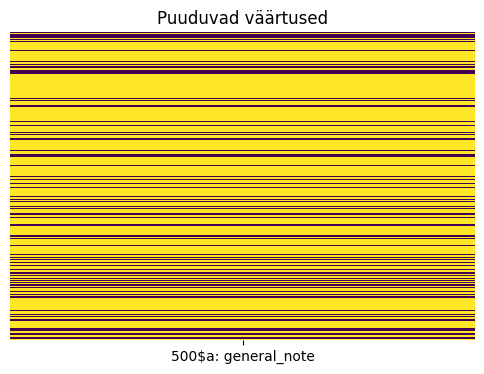

In [247]:
missing_values_heatmap(df.to_frame())

In [248]:
def clean_500a(entry):
    tiraaz = None
    hind = None
    kirjastiil = None
    if type(entry) == str:

        pattern_500a_tiraaz = re.compile(r"(?P<tiraaz>\d+(\.\d+)?)\s(eks\.?)")
        match = re.search(pattern_500a_tiraaz, entry)
        if match:
            tiraaz = int(match.groupdict()["tiraaz"].replace('.', ''))

        pattern_500a_hind = re.compile(r"(?P<rubla>\d\s(rbl\.?|rubla))?\s*(?P<kop>\d{1,2}\skop)")
        match = re.search(pattern_500a_hind, entry)
        if match:
            hind = match.string[match.span()[0]:match.span()[1]]

        pattern_500a_kirjastiil = re.compile(r"(?P<kirjastiil>[Ff]raktuur|[Aa]ntiikva)")
        match = re.search(pattern_500a_kirjastiil, entry)
        if match:
            kirjastiil = (match.groupdict()["kirjastiil"].lower()[0])

    return (tiraaz, hind, kirjastiil)

In [249]:
df = df.to_frame()
df[["tiraaz", "hind", "kirjastiil"]] = df["500$a"].apply(clean_500a).to_list()

Täidetus:
tiraaz: 5 %
hind: 2 %
kirjastiil: 7 %


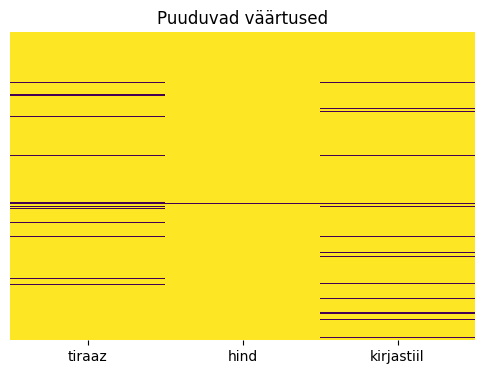

In [250]:
# tiraazi, hinna ja kirjastiili täituvus eraldi on väga madal. Kas jätta sisse või ei?
missing_values_heatmap(df[["tiraaz", "hind", "kirjastiil"]])

In [251]:
# millised on kõige sagedasemad üldmärkused, mis ei sisalda hinda, tiraazi ega kirjastiili?
df.loc[(df["tiraaz"].isna()) & (df["hind"].isna()) & (df["kirjastiil"].isna()), "500$a"].value_counts()[:20]
# siit vist väga midagi enam välja ei võta

Päistiitel                                           3002
Kaanel autor märkimata                               2696
Autoreferaat                                         1230
Kirjeldatud trükise alusel                           1216
Kaanel autorid märkimata                             1059
Mimeograafpaljundus                                   920
Kaanel ainult seeriapealkiri                          823
Kirjeldatud kaane järgi                               704
Autor näidatud tiitellehe pöördel                     595
Kaanel pealkiri märkimata                             527
Autorid näidatud tiitellehe pöördel                   502
Kaanel pealkiri ja autor märkimata                    472
Autor näidatud tagakaanel                             442
Võrguväljaandes puuduvad trükises toodud väite...     437
Tekst lehe ühel küljel                                422
ERRB märksõna: Luule - juhuluule - leinaluule         384
Ilmumisaasta allikas: Eesti raamatute üldnimes...     319
ERRB märksõna:

### Algupärandi märkus (534c)

In [252]:
df = df_main["534$c"].copy().to_frame()

Täidetus:
534$c: original_version_distribution: 6 %


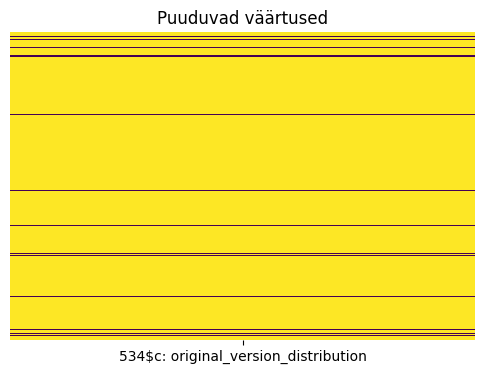

In [253]:
missing_values_heatmap(df)

In [254]:
for i in df["534$c"].value_counts().index[:2000]:
    print(i)

1938
1935
1939
1934
1937
1940
1936
1933
1932
1929
1930
1931
1926
1928
1927
[Tallinn : Eestimaa Konsistooriumi kirjastuskassa], 1721
1925
Tallinn : Ersen, 2012
Tallinn : Varrak, 2013
Tallinn : Varrak, 2014
Riga, 1690-1691
Kuresaare, 1864
1924
Tartu : Loodus, 1936
Tallinn : Ersen, 2008
1923
1911
[Tallinn : Eestimaa Konsisooriumi kirjastuskassa], 1721
[Tallinn : Eestimaa Konsistooriumi kirjastuskassa], 1740
Tallinn : Raamatu Sõber, 1930
1900
1913
1910
Rijan, 1685
1902
1898
1912
Tallinn : Koolibri, 1999
Tartu : Loodus, 1935
1903
Tallinn : Varrak, 2011
1941
Tartu : Loodus, 1929
Revall, [1638]
1905
Tartu : Loodus, 1924
Tallinn : Varrak, 2012
Tallinn, 1739
1901
Tallinn : Ersen, 2007
Tartu : Loodus, 1922
1895
1904
Tallinn : Ersen, 2013
1906
1943
1909
1892
1718
1897
1899
Leningrad : Külvaja, 1933
Tallinn : Eesti Kirjastus, 1942
Tallinn : Eesti Raamat, 1985
Tartu : Loodus, 1921
1908
Tallinn : Koolibri, 2012
1922
Tartu : Loodus, 1925
1914
Tallinn : Koolibri, 2002
1907
Tarto linnas, 1842
1933-1934

In [255]:
pattern_534c = re.compile(r"((?P<place>[A-ZÕÄÖÜ]\w+(\s\;\s[A-ZÕÄÖÜ]\w+)?)(\s?\:\s((?P<publisher>((([A-Z&]+\s)?[A-ZÕÄÖÜk]\w+(\s|\-)?)+)|(s\.\s?n\.)|(([A-ZÕÄÖÜ]\.\s)+[A-ZÕÄÖÜ]\w+))))?)?(,\s)?c?(?:([IVXLCDM]+\s)+)?((?P<range>\d{4}\-\d{4})|(?P<year>\d{4}))?")

In [256]:
pattern_534c = re.compile("((?P<place>([A-ZÕÄÖÜ]\w+|[А-Я][а-я]+)(\s\;\s[A-ZÕÄÖÜ]\w+)?)?(\s?\:\s((?P<publisher>((([A-Z&]+\s)?[A-ZÕÄÖÜk]\w+(\s|\-)?)+)|(s\.\s?n\.)|((([A-ZÕÄÖÜ]|[А-Я])\.\s)+([A-ZÕÄÖÜ]\w+|[А-Я][а-я]+)))))?)?(,\s)?c?(?:([IVXLCDM]+\s)+)?((?P<range>\d{4}\-\d{4})|(?P<year>\d{4}))?")

In [257]:
def clean_534c(entry, pattern=pattern_534c):
    year = None
    place = None
    publisher = None
    if type(entry) == str:
        entry = entry.lstrip().replace('[', '').replace(']', '')
        match = re.search(pattern, entry)
        if match:
            matchgroups = match.groupdict()
            if matchgroups["year"]:
                year = int(matchgroups["year"])
            if matchgroups["place"]:
                place = matchgroups["place"]
            if matchgroups["publisher"]:
                publisher = matchgroups["publisher"]
            if matchgroups["range"]:
                year = int(matchgroups["range"].split("-")[0])

    return (year, place, publisher)

In [258]:
re.search(pattern_534c, '"Loodus", 1934')

<re.Match object; span=(0, 0), match=''>

In [259]:
clean_534c('"Loodus", 1934')

(None, None, None)

In [260]:
df[["original_distribution_year", "original_distribution_place", "original_distribution_publisher"]] = df["534$c"].apply(clean_534c).to_list()
df = df.convert_dtypes()

In [261]:
df.loc[df["534$c"].notna()].sample(10)

,534$c,original_distribution_year,original_distribution_place,original_distribution_publisher
128125,"Rijan, 1685",1685,Rijan,<NA>
70011,1846,1846,<NA>,<NA>
160991,"Tallinn : Eesti Raamat, 1988",1988,Tallinn,Eesti Raamat
31475,1911,1911,<NA>,<NA>
683,"Moskva, 1979",1979,Moskva,<NA>
200448,"Tartu : Eesti Kirjanduse Selts, 1933",1933,Tartu,Eesti Kirjanduse Selts
148864,"[Tallinn] : Egmont Estonia, c2014",2014,Tallinn,Egmont Estonia
71185,"1862, январь",1862,<NA>,<NA>
200492,"[Tallinn] : Huma, c2003",2003,Tallinn,Huma
136600,"Tallinn : elf, 1994",<NA>,Tallinn,<NA>


In [493]:
regex_coverage(df, "534$c", pattern_534c)

Regex katab 13787 kirjet 13787 kirjest
Kaetus:  100.0 %


In [499]:
### katmata jääavad segased kirjed, kirillitsas kohanimed jne
df.loc[(df["534$c"].notna()) & (df["original_distribution_year"].isna()) & (df["original_distribution_place"].isna()) & (df["original_distribution_publisher"].isna())]

,534$c,original_distribution_year,original_distribution_place,original_distribution_publisher
592,nr. 15-23,<NA>,<NA>,<NA>
1008,"""Jutuleht"" 1929",<NA>,<NA>,<NA>
5215,"kirjastus osaühing ""Loodus"", 1940",<NA>,<NA>,<NA>
5420,"K/Ü Looduse, 1935",<NA>,<NA>,<NA>
5444,"K.-ü. Rahvaülikool, 1939",<NA>,<NA>,<NA>
...,...,...,...,...
128334,"(1996), nr. 8-9",<NA>,<NA>,<NA>
135887,7.-16. oktoober 1976,<NA>,<NA>,<NA>
177399,"[S.l. : s.n.], 1941",<NA>,<NA>,<NA>
195725,"12. detsember 1921, nr. 44",<NA>,<NA>,<NA>


### Autoriõiguse info (542l)

In [500]:
df = df_main["542$l"].copy()

Täidetus:
542$l: copyright_status: 13 %


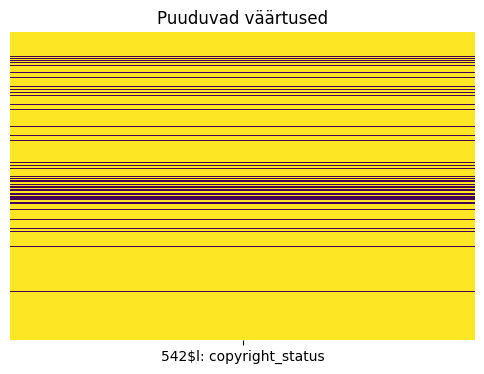

In [501]:
missing_values_heatmap(df.to_frame())

In [502]:
### jätame sisse, aga kas võiks kasutada lühendeid/koode?
df.value_counts()

Vabakasutus                 27178
Orbteos                       643
Osaline orbteos                23
Kehtiv autoriõigus              1
Vabakasutus; Vabakasutus        1
Name: 542$l, dtype: int64

### Isikumärksõna (600)

In [10]:
df = df_main["600"].copy()

Täidetus:
600: subject_person: 7 %


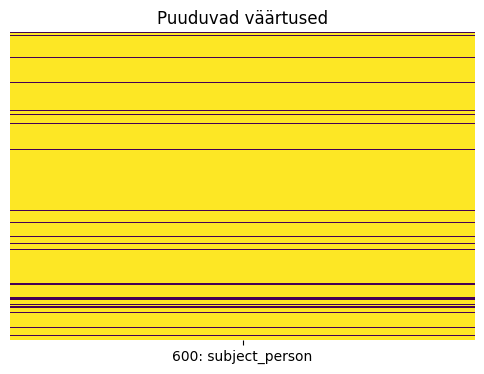

In [11]:
missing_values_heatmap(df.to_frame())

In [15]:
# tundub, et siin on üldiselt korras?
df.loc[df.notna()].sample(10)

135871                                  Siib, Liina (1963-)
189990                                   Paju, Aili (1938-)
17814                            Laigo, Arkadio (1901-1944)
96906                                 Pieder, Jüri [omanik]
162963    Särak, Voldemar (1911-1947); Hellat, Toomas (1...
8510                       Baer, Karl Ernst von (1792-1876)
193277                     Hagen-Schwarz, Julie (1824-1902)
168649                          Grenzstein, Ado (1849-1916)
123627                              Vare, Vello (1923-2007)
172594    Wühner, Hans (1836-1911); Kissa, Jaak (1843-19...
Name: 600, dtype: object

### Ajamärksõna (648a)

In [135]:
df = df_main["648$a"].copy()

Täidetus:
648$a: subject_chronological_term: 5 %


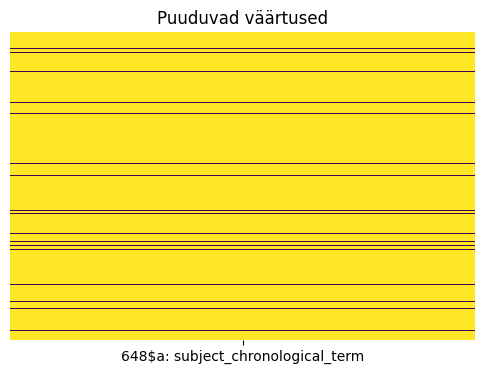

In [137]:
missing_values_heatmap(df.to_frame())

In [143]:
df.value_counts()[:100].sum() / len(df[df.notna()])

0.875974972143653

In [145]:
pattern_648a = re.compile(r"(?P<century>\d{1,2}\. saj\.?(\s(((1|2)\.)\spool)|\salgus|\slõpp)?)|(?P<decade>\d{4}\-ndad)|(?P<range>\d{4}\-\d{4})|(?P<year>\d{4})")

In [150]:
def clean_648a(entry, pattern=pattern_648a):
    year = None
    range = None
    decade = None
    century = None
    if type(entry) == str:
        entry_split = entry.split("; ")
        for part in entry_split:
            match = re.search(pattern, entry)
            if match:
                if century
                century, decade, range, year = match.groupdict().values()

    return (year, range, decade, century)


In [153]:
df = df.to_frame()
df[["year", "range", "decade", "century"]] = df["648$a"].apply(clean_648a).to_list()

In [157]:
df.loc[df["648$a"].notna()].sample(10)

,648$a,year,range,decade,century
96531,1980-ndad,None,None,1980-ndad,None
144352,1990-ndad; 2000-ndad,None,None,1990-ndad,None
145829,1810-ndad,None,None,1810-ndad,None
5298,1918-1940,None,1918-1940,None,None
1140,20. saj,None,None,None,20. saj
57683,1970-ndad,None,None,1970-ndad,None
58851,1940-1945,None,1940-1945,None,None
9828,1980-ndad; 1990-ndad,None,None,1980-ndad,None
181555,18. saj; 19. saj; 20. saj,None,None,None,18. saj
172218,20. saj. 2. pool; 21. saj. algus,None,None,None,20. saj. 2. pool


### Isikunime täiendkirje e. contributor (700)

In [8]:
df = df_main["700"].copy()

In [9]:
### näiteid; võib kontrollida, kas siin on kõik korras ja kas peaks täiendama. kas VIAFi tõstaksime samasse tulpa nt looksulgudesse või on mõni parem variant?
for val in df.loc[df.notna()].sample(10).values:
    print(val)

Jürjo, Merike (1959-) [koostaja]; Nõmm, Aart (1976-) [koostaja]; Ojalo, Hanno (1961-) [koostaja]; Arumäe, Ivika (1961-) [toimetaja]; Garshnek, Jan (1981-) [kujundaja]
Lepp, Mart (1947-) [teksti autor]; Lepp, Mart (1947-) [kujundaja]
Kallo, Ferdinand (1912-1987) [tõlkija]
Lepasalu, Rajur (1917-1942) [autor]
Randmaa, Aldo (1969-) [tõlkija]; Maran, Olav (1933-) [toimetaja]; Kurg, Ingmar (1955-) [toimetaja]; Sildre, Tiina (1959-) [kujundaja]
Bjömson, B: "Hädaohtlik kosimine"; Kielland, Alexander L (1849-1906): "Kolletanud Lehed"; Strindberg, August (1849-1912): "Üle pilvede"; Bjömson, B: "Kõrb"; Kielland, Alexander L (1849-1906): "Rahvapidu"; Kielland, Alexander L (1849-1906): "Pealelõunane unenägu"; Kielland, Alexander L (1849-1906): "Pidutuju"; Strindberg, August (1849-1912): "Rätsepa tantsupidu"; Strindberg, August (1849-1912): "Võitlus iseseisvuse eest"; Bjömson, B: "Thrond"
Krusten, Reet (1934-2021) [koostaja]; Leete, Eve [toimetaja]; Saar, Olivia (1931-) [toimetaja]; Saare, Krista (1

### Kollektiivi täiendkirje (710)

In [20]:
df = df_main["710"].copy()

Täidetus:
710: corporate_unit: 30 %


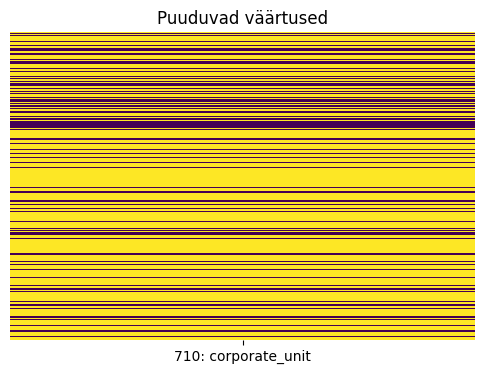

In [22]:
missing_values_heatmap(df.to_frame())

In [24]:
df.loc[df.notna()].sample(10)

145528                               Enge Põllumeeste Selts
15071                            Eesti Põllumajandusprojekt
69199     Eesti NSV Põllumajandusministeerium [Teaduslik...
34556                          Eesti NSV Agrotööstuskoondis
84646          Eesti NSV Tehnilise Informatsiooni Keskbüroo
38130     Eesti Majandusjuhtide Instituut [Ühiskonnatead...
151461                 Euroopa Majandus- ja Sotsiaalkomitee
59827        Nõukogude Liidu Kommunistlik Partei [Kongress]
74142     Eesti NSV Ühiskondliku Korra Kaitse Ministeeri...
40010                                         Teadus, ühing
Name: 710, dtype: string

### Vabapealkiri (740a)

In [25]:
df = df_main["740$a"].copy()

Täidetus:
740$a: uncontrolled_related_title: 7 %


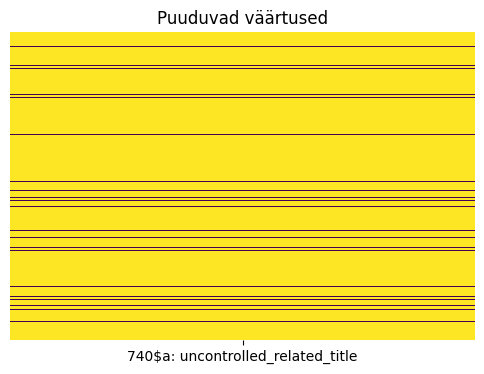

In [26]:
missing_values_heatmap(df.to_frame())

In [244]:
### seda pole vist mõtet harmoniseerida, aga võib sisse jätta
df.value_counts()[:30]

ELIKbaas                                                                                                                      1174
Eesti trükise punane raamat II, 1851-1917. Rariteedid                                                                          716
Eesti trükise punane raamat II, 1851-1917. Kultuuriloolised valikud                                                            515
Eesti trükise punane raamat I, 1535-1850                                                                                       510
Peep Sürje kogu                                                                                                                175
Sada rooga                                                                                                                     167
EV 100                                                                                                                         155
Eesti trükise punane raamat II, 1851-1917. Kultuuriloolised valikud; Eesti trükise 

### Hierarhiline kohanimi (752 c, d)

In [245]:
df = df_main[["752$c", "752$d"]]

Täidetus:
752$c: added_intermediate_political_jurisdiction: 32 %
752$d: added_city: 2 %


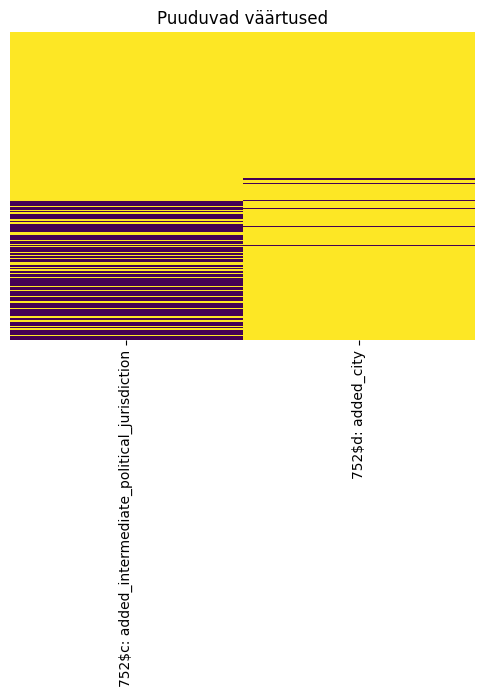

In [246]:
missing_values_heatmap(df)

In [267]:
df["752$c"].value_counts()[:20]

Harjumaa              55873
Tartumaa               8991
Pärnumaa               1230
Viljandimaa             640
Järvamaa                616
Lääne-Virumaa           559
Võrumaa                 547
Jõgevamaa               496
Ida-Virumaa             438
Saaremaa                407
Raplamaa                399
Läänemaa                330
Põlvamaa                300
Valgamaa                297
Hiiumaa                 140
Harjumaa; Harjumaa       27
Leningradi oblast        16
Venemaa                   9
Berliin                   6
Tallinn                   4
Name: 752$c, dtype: int64

In [268]:
df["752$d"].value_counts()[:20]

Tartu                              1800
Tallinn                            1210
Riia                                183
Viljandi                            181
Kuressaare                          157
Paide                               117
Pärnu                                93
Võru                                 89
Peterburi                            84
Rakvere                              74
Valga                                61
Narva                                48
Tallinn; Tallinn, trükkimiskoht      35
Leningrad                            34
Moskva                               33
Tallinn, trükkimiskoht               29
Tartu; Tartu, trükkimiskoht          27
Põltsamaa                            23
Tartu (trükkimiskoht)                22
Aegviidu                             19
Name: 752$d, dtype: int64

In [ ]:
### need väljad täidetakse põhimõtteliselt ainult Eesti puhul. Mida teeme?

### Elektrooniline juurdepääs e. URI (856$u)

In [ ]:
df = df_main["856$u"].copy().to_frame()

Täidetus:
856$u: electronic_access_URI: 37 %


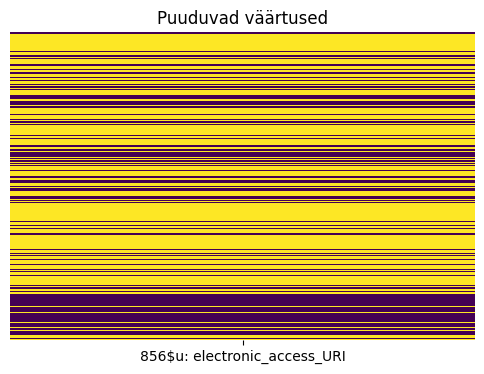

In [ ]:
missing_values_heatmap(df)

In [ ]:
### siin tundub kõik korras olevat
df.sample(10)

,856$u
47121,http://www.digar.ee/id/nlib-digar:652941
46305,https://www.digar.ee/id/nlib-digar:101448; htt...
108600,NaN
1088,NaN
158649,NaN
87296,NaN
215714,http://www.digar.ee/id/nlib-digar:886408
11676,NaN
186584,NaN
51718,NaN


In [ ]:
from urllib.parse import urlparse

def is_valid_url(url):
    parsed_url = urlparse(url)
    return bool(parsed_url.scheme and parsed_url.netloc)

def validate_856u(entry):
    if type(entry) == str:
        valid = []
        entry_split = entry.split("; ")
        for url in entry_split:
            valid.append(is_valid_url(url))
        if False not in valid:
            return True
        else:
            return False
    else:
        return None

In [ ]:
bool(
    urlparse("http://kivike.kirmus.ee/AR-17101-53943-52626").scheme and
    urlparse("http://kivike.kirmus.ee/AR-17101-53943-52626").netloc
)
    

True

In [ ]:
df["valid_url"] = df["856$u"].apply(validate_856u)

In [ ]:
def clean_856u(entry):
    if type(entry) == str:
        entry_split = entry.split("; ")
        return "; ".join([url.strip().lstrip() for url in entry_split if is_valid_url(url.strip().lstrip())])

In [ ]:
df["856$u_cleaned"] = df["856$u"].apply(clean_856u)

In [ ]:
df.loc[df["856$u"].notna()].sample(10)

,856$u,valid_url,856$u_cleaned
124826,https://www.digar.ee/id/nlib-digar:273420,True,https://www.digar.ee/id/nlib-digar:273420
122996,http://kivike.kirmus.ee/AR-23313-36137-62562,True,http://kivike.kirmus.ee/AR-23313-36137-62562
212539,http://www.digar.ee/arhiiv/nlib-digar:913574; ...,True,http://www.digar.ee/arhiiv/nlib-digar:913574; ...
64015,http://hdl.handle.net/10062/55596,True,http://hdl.handle.net/10062/55596
126206,https://www.digar.ee/id/nlib-digar:103547,True,https://www.digar.ee/id/nlib-digar:103547
217886,https://www.digar.ee/arhiiv/nlib-digar:984688,True,https://www.digar.ee/arhiiv/nlib-digar:984688
210136,http://www.digar.ee/arhiiv/nlib-digar:680990,True,http://www.digar.ee/arhiiv/nlib-digar:680990
169851,http://ellu.keskraamatukogu.ee/book/9789949495...,True,http://ellu.keskraamatukogu.ee/book/9789949495...
205004,https://www.digar.ee/id/nlib-digar:602148,True,https://www.digar.ee/id/nlib-digar:602148
165870,http://www.digar.ee/id/nlib-digar:210030,True,http://www.digar.ee/id/nlib-digar:210030
